# Siamese Net for Speaker Identification using spectogram images of speech data, leveraging Cross Entropy Loss, and with added Dropout layer for regularization

In [44]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.3.0+cu100
# CUDA enabled: True

Version 1.3.1
CUDA enabled: True


In [0]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [0]:
import os
BASE_PATH = '/gdrive/Shared drives/Deep Learning Project'
os.chdir(BASE_PATH)

In [0]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Configuration Class
A simple class to manage configuration

In [0]:
import os
BASE_PATH = '/gdrive/Shared drives/Deep Learning Project'
os.chdir(BASE_PATH)

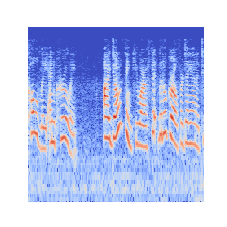

In [9]:
Image.open('train-gram/0/90de1a6f261f44d9823ab46133ca1259.png')

In [0]:
class Config():
    training_dir = BASE_PATH + "/train-gram/"
    testing_dir = BASE_PATH + "/test-gram/"
    testing_dir_own = BASE_PATH + "/team-spectrogram/"
    train_batch_size = 256
    train_number_epochs = 10

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [0]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        ## Conversion to grayscale
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        labels = torch.squeeze(torch.from_numpy(np.array([int(img1_tuple[1]==img0_tuple[1])],dtype=np.float32)).long())
        ## Set the Label to 1 when the images are from the same class
        return img0, img1 , labels
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Using Image Folder Dataset

In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
num_workers = multiprocessing.cpu_count()
print('num workers:', num_workers)
kwargs = {'num_workers': num_workers,
          'pin_memory': True} if use_cuda else {}

Using device cuda
num workers: 2


In [0]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([#transforms.Resize((227,227)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)
train_dataloader = DataLoader(siamese_dataset,
                              shuffle=True,
                              batch_size=Config.train_batch_size,
                              **kwargs)

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates samle class, and 0 indicates not the same class.

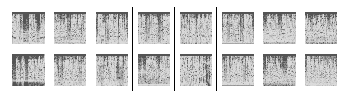

[0 0 1 0 0 1 1 0]


In [14]:
vis_dataloader = DataLoader(siamese_dataset, shuffle=True,         
                            batch_size=8, **kwargs)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Neural Net Definition
We will use a standard convolutional neural network

In [0]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*227*227, 512),
            nn.ReLU(inplace=True),
            ## Using 30% dropout probability
            nn.Dropout(p=0.3),
            )
        ## Final linear layer output dim is 2: where one of them
        ## corresponds to saying the datapoints match and the other indicates that it doesn't
        self.fc2 = nn.Linear(512, 2)

    def forward_per_datapoint(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_per_datapoint(input1)
        output2 = self.forward_per_datapoint(input2)
        return self.fc2(torch.abs(output1 - output2))

## Cross Entropy Loss

In [0]:
class CrossEntropyLoss(torch.nn.Module):
    def __init__(self):
        super(CrossEntropyLoss, self).__init__()

    def forward(self, output, label):
        label = label.long()
        loss = F.cross_entropy(output, label)
        return loss

## Training Time!

In [0]:
net = SiameseNetwork().to(device)
criterion = CrossEntropyLoss().to(device)
optimizer = optim.Adam(net.parameters(), lr = 0.001)

In [20]:
net

SiameseNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU(inplace=True)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=412232, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
  )
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [0]:
counter = []
loss_history = [] 
iteration_number= 0

In [0]:
def train(model, device, train_loader, epoch):
    model.train()
    losses = []
    accurate_labels = 0
    all_labels = 0
    len_train_loader = len(train_loader)
    for batch_idx, (data0, data1, label) in enumerate(tqdm.tqdm(train_loader)): #tqdm.tqdm(train_loader)
        data0, data1, label = data0.to(device), data1.to(device), label.to(device)
        optimizer.zero_grad()
        
        out = model(data0, data1)
        loss_function = criterion(out, label)
        losses.append(loss_function.item())
        loss_function.backward()
        
        optimizer.step()
        
        accurate_labels += torch.sum(torch.argmax(out, dim=1) == label).cpu()
        all_labels += len(label)
            
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTrain Accuracy: {:.6f}'.format(
                epoch, (batch_idx+1) * len(data0), len(train_loader.dataset),
                100. * (batch_idx+1) / len(train_loader), loss_function.item(),
                (100. * accurate_labels / all_labels)))
    train_loss = np.mean(losses)
    train_accuracy = 100. * accurate_labels / all_labels
    print('\nTrain set: Average loss = {:.4f}, Train Accuracy = {:.4f}\n'.format(train_loss, train_accuracy))
    return train_loss, train_accuracy

In [0]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.ToTensor()]),
                                        should_invert=False)

test_dataloader = DataLoader(siamese_dataset, batch_size=256, shuffle=False, **kwargs)

In [0]:
def test(model, device, test_loader):
    model.eval()
    accurate_labels = 0
    all_labels = 0
    losses = []
    with torch.no_grad():
        for batch_idx, (data0, data1, label) in enumerate(tqdm.tqdm(test_loader)):
            data0, data1, label = data0.to(device), data1.to(device), label.to(device)
            out = model(data0, data1)
            loss_function = criterion(out, label)
            losses.append(loss_function.item())

            accurate_labels += torch.sum(torch.argmax(out, dim=1) == label).cpu()
            all_labels += len(label)
    test_loss = np.mean(losses)
    test_accuracy = 100. * accurate_labels / all_labels
    print('\nTest set: Average loss = {:.4f}, Test Accuracy = {:.4f}\n'.format(test_loss, test_accuracy))
    return test_loss, test_accuracy

In [0]:
EPOCHS = 50

In [0]:
import tqdm
import time

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [28]:
len(test_dataloader)

55

In [31]:
len(train_dataloader)

215

In [30]:
test(net, device, test_dataloader)

100%|██████████| 55/55 [35:00<00:00, 38.19s/it]


Test set: Average loss = 0.6931, Test Accuracy = 50.2675



(0.6931381496516141, tensor(50.2675))

In [32]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
best_test_accuracy = 0.0
for epoch in range(0, EPOCHS):
    print("Epoch number: ", epoch)
    start_time = time.time()
    print("\nTraining:")
    train_loss, train_accuracy = train(net, device, train_dataloader, epoch)
    print("\nTesting:")
    test_loss, test_accuracy = test(net, device, test_dataloader)
    train_losses.append((epoch, train_loss))
    test_losses.append((epoch, test_loss))
    train_accuracies.append((epoch, train_accuracy))
    test_accuracies.append((epoch, test_accuracy))
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        torch.save(net.state_dict(), 'siamese_net_crossEntropy_withDropout.pt')
    end_time = time.time()
    print("Time taken for running epoch {} is {:.3f} seconds.\n\n".format(epoch, end_time-start_time))

  0%|          | 0/215 [00:00<?, ?it/s]

Epoch number:  0

Training:


  0%|          | 1/215 [02:59<10:41:35, 179.88s/it]

Train Epoch: 0 [256/54863 (0%)]	Loss: 0.700747	Train Accuracy: 50.000000


 10%|▉         | 21/215 [30:17<4:49:16, 89.47s/it]

Train Epoch: 0 [5376/54863 (10%)]	Loss: 6.080494	Train Accuracy: 52.752975


 19%|█▉        | 41/215 [53:39<3:29:41, 72.31s/it]

Train Epoch: 0 [10496/54863 (19%)]	Loss: 0.949686	Train Accuracy: 54.011051


 28%|██▊       | 61/215 [1:13:10<2:38:02, 61.57s/it]

Train Epoch: 0 [15616/54863 (28%)]	Loss: 0.689511	Train Accuracy: 55.206200


 38%|███▊      | 81/215 [1:28:56<1:57:39, 52.68s/it]

Train Epoch: 0 [20736/54863 (38%)]	Loss: 0.688485	Train Accuracy: 56.129436


 47%|████▋     | 101/215 [1:42:43<1:33:12, 49.06s/it]

Train Epoch: 0 [25856/54863 (47%)]	Loss: 0.676931	Train Accuracy: 56.980972


 56%|█████▋    | 121/215 [1:54:03<54:10, 34.58s/it]

Train Epoch: 0 [30976/54863 (56%)]	Loss: 0.658377	Train Accuracy: 57.363766


 66%|██████▌   | 141/215 [2:03:17<38:52, 31.52s/it]

Train Epoch: 0 [36096/54863 (66%)]	Loss: 0.646942	Train Accuracy: 57.804188


 75%|███████▍  | 161/215 [2:11:35<26:44, 29.72s/it]

Train Epoch: 0 [41216/54863 (75%)]	Loss: 0.643610	Train Accuracy: 58.263783


 84%|████████▍ | 181/215 [2:17:58<11:20, 20.02s/it]

Train Epoch: 0 [46336/54863 (84%)]	Loss: 0.636505	Train Accuracy: 58.697342


 93%|█████████▎| 201/215 [2:23:08<03:47, 16.27s/it]

Train Epoch: 0 [51456/54863 (93%)]	Loss: 0.629783	Train Accuracy: 59.009640


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 5.4722, Train Accuracy = 59.1619


Testing:


100%|██████████| 55/55 [06:04<00:00,  6.62s/it]



Test set: Average loss = 0.6014, Test Accuracy = 69.5879



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 0 is 9136.247 seconds.


Epoch number:  1

Training:


  0%|          | 1/215 [00:26<1:34:29, 26.49s/it]

Train Epoch: 1 [256/54863 (0%)]	Loss: 0.650851	Train Accuracy: 60.937500


 10%|▉         | 21/215 [04:12<28:45,  8.89s/it]

Train Epoch: 1 [5376/54863 (10%)]	Loss: 0.616966	Train Accuracy: 62.630207


 19%|█▉        | 41/215 [07:47<33:23, 11.51s/it]

Train Epoch: 1 [10496/54863 (19%)]	Loss: 0.618400	Train Accuracy: 62.842987


 28%|██▊       | 61/215 [11:14<30:38, 11.94s/it]

Train Epoch: 1 [15616/54863 (28%)]	Loss: 0.645551	Train Accuracy: 62.711323


 38%|███▊      | 81/215 [13:56<16:49,  7.54s/it]

Train Epoch: 1 [20736/54863 (38%)]	Loss: 0.651174	Train Accuracy: 62.880981


 47%|████▋     | 101/215 [16:04<14:27,  7.61s/it]

Train Epoch: 1 [25856/54863 (47%)]	Loss: 0.643588	Train Accuracy: 62.786201


 56%|█████▋    | 121/215 [17:59<09:44,  6.22s/it]

Train Epoch: 1 [30976/54863 (56%)]	Loss: 0.606827	Train Accuracy: 62.761494


 66%|██████▌   | 141/215 [19:24<05:27,  4.43s/it]

Train Epoch: 1 [36096/54863 (66%)]	Loss: 0.623136	Train Accuracy: 62.837986


 75%|███████▍  | 161/215 [20:42<03:17,  3.65s/it]

Train Epoch: 1 [41216/54863 (75%)]	Loss: 0.652922	Train Accuracy: 62.788723


 84%|████████▍ | 181/215 [22:02<02:19,  4.11s/it]

Train Epoch: 1 [46336/54863 (84%)]	Loss: 0.651915	Train Accuracy: 62.812931


 93%|█████████▎| 201/215 [23:08<00:47,  3.41s/it]

Train Epoch: 1 [51456/54863 (93%)]	Loss: 0.615938	Train Accuracy: 62.826492


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.6331, Train Accuracy = 62.8748


Testing:


100%|██████████| 55/55 [01:53<00:00,  2.07s/it]



Test set: Average loss = 0.5959, Test Accuracy = 72.4584



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 1 is 1546.515 seconds.


Epoch number:  2

Training:


  0%|          | 1/215 [00:08<29:34,  8.29s/it]

Train Epoch: 2 [256/54863 (0%)]	Loss: 0.607116	Train Accuracy: 69.921875


 10%|▉         | 21/215 [01:08<11:57,  3.70s/it]

Train Epoch: 2 [5376/54863 (10%)]	Loss: 0.594584	Train Accuracy: 63.541668


 19%|█▉        | 41/215 [02:02<07:37,  2.63s/it]

Train Epoch: 2 [10496/54863 (19%)]	Loss: 0.658832	Train Accuracy: 64.043442


 28%|██▊       | 61/215 [02:58<09:14,  3.60s/it]

Train Epoch: 2 [15616/54863 (28%)]	Loss: 0.617117	Train Accuracy: 63.761528


 38%|███▊      | 81/215 [03:40<04:50,  2.17s/it]

Train Epoch: 2 [20736/54863 (38%)]	Loss: 0.613474	Train Accuracy: 63.975693


 47%|████▋     | 101/215 [04:24<03:53,  2.05s/it]

Train Epoch: 2 [25856/54863 (47%)]	Loss: 0.645114	Train Accuracy: 63.842049


 56%|█████▋    | 121/215 [05:06<02:51,  1.82s/it]

Train Epoch: 2 [30976/54863 (56%)]	Loss: 0.631618	Train Accuracy: 64.014076


 66%|██████▌   | 141/215 [05:48<03:03,  2.48s/it]

Train Epoch: 2 [36096/54863 (66%)]	Loss: 0.640825	Train Accuracy: 64.126221


 75%|███████▍  | 161/215 [06:25<01:43,  1.92s/it]

Train Epoch: 2 [41216/54863 (75%)]	Loss: 0.598905	Train Accuracy: 64.101318


 84%|████████▍ | 181/215 [07:02<01:00,  1.79s/it]

Train Epoch: 2 [46336/54863 (84%)]	Loss: 0.630691	Train Accuracy: 64.185516


 93%|█████████▎| 201/215 [07:39<00:25,  1.84s/it]

Train Epoch: 2 [51456/54863 (93%)]	Loss: 0.613316	Train Accuracy: 64.326805


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.6237, Train Accuracy = 64.3785


Testing:


100%|██████████| 55/55 [01:28<00:00,  1.62s/it]



Test set: Average loss = 0.5867, Test Accuracy = 73.0513



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 2 is 578.418 seconds.


Epoch number:  3

Training:


  0%|          | 1/215 [00:04<17:37,  4.94s/it]

Train Epoch: 3 [256/54863 (0%)]	Loss: 0.624687	Train Accuracy: 64.453125


 10%|▉         | 21/215 [00:46<06:37,  2.05s/it]

Train Epoch: 3 [5376/54863 (10%)]	Loss: 0.621711	Train Accuracy: 65.308777


 19%|█▉        | 41/215 [01:28<06:33,  2.26s/it]

Train Epoch: 3 [10496/54863 (19%)]	Loss: 0.615967	Train Accuracy: 65.177208


 28%|██▊       | 61/215 [02:08<04:50,  1.88s/it]

Train Epoch: 3 [15616/54863 (28%)]	Loss: 0.621645	Train Accuracy: 64.536369


 38%|███▊      | 81/215 [02:45<04:06,  1.84s/it]

Train Epoch: 3 [20736/54863 (38%)]	Loss: 0.594496	Train Accuracy: 64.882332


 47%|████▋     | 101/215 [03:22<03:37,  1.91s/it]

Train Epoch: 3 [25856/54863 (47%)]	Loss: 0.650224	Train Accuracy: 64.762527


 56%|█████▋    | 121/215 [03:59<02:49,  1.80s/it]

Train Epoch: 3 [30976/54863 (56%)]	Loss: 0.620116	Train Accuracy: 64.601624


 66%|██████▌   | 141/215 [04:34<02:14,  1.81s/it]

Train Epoch: 3 [36096/54863 (66%)]	Loss: 0.603829	Train Accuracy: 64.674759


 75%|███████▍  | 161/215 [05:09<01:33,  1.72s/it]

Train Epoch: 3 [41216/54863 (75%)]	Loss: 0.617530	Train Accuracy: 64.778244


 84%|████████▍ | 181/215 [05:44<00:59,  1.76s/it]

Train Epoch: 3 [46336/54863 (84%)]	Loss: 0.593514	Train Accuracy: 64.925758


 93%|█████████▎| 201/215 [06:18<00:24,  1.73s/it]

Train Epoch: 3 [51456/54863 (93%)]	Loss: 0.627495	Train Accuracy: 65.059471


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.6182, Train Accuracy = 65.0384


Testing:


100%|██████████| 55/55 [01:23<00:00,  1.52s/it]



Test set: Average loss = 0.5682, Test Accuracy = 74.1432



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 3 is 488.751 seconds.


Epoch number:  4

Training:


  0%|          | 1/215 [00:05<19:44,  5.54s/it]

Train Epoch: 4 [256/54863 (0%)]	Loss: 0.610069	Train Accuracy: 66.796875


 10%|▉         | 21/215 [00:47<06:55,  2.14s/it]

Train Epoch: 4 [5376/54863 (10%)]	Loss: 0.647526	Train Accuracy: 64.713539


 19%|█▉        | 41/215 [01:24<05:35,  1.93s/it]

Train Epoch: 4 [10496/54863 (19%)]	Loss: 0.642126	Train Accuracy: 64.853279


 28%|██▊       | 61/215 [02:03<05:01,  1.96s/it]

Train Epoch: 4 [15616/54863 (28%)]	Loss: 0.601129	Train Accuracy: 64.754097


 38%|███▊      | 81/215 [02:40<04:15,  1.90s/it]

Train Epoch: 4 [20736/54863 (38%)]	Loss: 0.534792	Train Accuracy: 65.248840


 47%|████▋     | 101/215 [03:17<03:33,  1.87s/it]

Train Epoch: 4 [25856/54863 (47%)]	Loss: 0.604795	Train Accuracy: 65.404549


 56%|█████▋    | 121/215 [03:53<02:55,  1.87s/it]

Train Epoch: 4 [30976/54863 (56%)]	Loss: 0.585732	Train Accuracy: 65.502327


 66%|██████▌   | 141/215 [04:28<02:10,  1.76s/it]

Train Epoch: 4 [36096/54863 (66%)]	Loss: 0.597229	Train Accuracy: 65.591759


 75%|███████▍  | 161/215 [05:03<01:34,  1.75s/it]

Train Epoch: 4 [41216/54863 (75%)]	Loss: 0.695909	Train Accuracy: 65.595886


 84%|████████▍ | 181/215 [05:37<00:57,  1.70s/it]

Train Epoch: 4 [46336/54863 (84%)]	Loss: 0.560163	Train Accuracy: 65.562416


 93%|█████████▎| 201/215 [06:11<00:23,  1.66s/it]

Train Epoch: 4 [51456/54863 (93%)]	Loss: 0.611123	Train Accuracy: 65.727997


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.6107, Train Accuracy = 65.8276


Testing:


100%|██████████| 55/55 [01:24<00:00,  1.55s/it]



Test set: Average loss = 0.5516, Test Accuracy = 76.2979



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 4 is 483.612 seconds.


Epoch number:  5

Training:


  0%|          | 1/215 [00:05<17:56,  5.03s/it]

Train Epoch: 5 [256/54863 (0%)]	Loss: 0.617765	Train Accuracy: 67.187500


 10%|▉         | 21/215 [00:45<06:31,  2.02s/it]

Train Epoch: 5 [5376/54863 (10%)]	Loss: 0.623567	Train Accuracy: 65.197174


 19%|█▉        | 41/215 [01:25<05:54,  2.04s/it]

Train Epoch: 5 [10496/54863 (19%)]	Loss: 0.594583	Train Accuracy: 65.967987


 28%|██▊       | 61/215 [02:03<05:06,  1.99s/it]

Train Epoch: 5 [15616/54863 (28%)]	Loss: 0.641753	Train Accuracy: 65.548157


 38%|███▊      | 81/215 [02:41<04:16,  1.91s/it]

Train Epoch: 5 [20736/54863 (38%)]	Loss: 0.554206	Train Accuracy: 65.779320


 47%|████▋     | 101/215 [03:18<03:36,  1.90s/it]

Train Epoch: 5 [25856/54863 (47%)]	Loss: 0.617439	Train Accuracy: 66.065903


 56%|█████▋    | 121/215 [03:54<02:47,  1.79s/it]

Train Epoch: 5 [30976/54863 (56%)]	Loss: 0.631251	Train Accuracy: 66.189957


 66%|██████▌   | 141/215 [04:31<02:29,  2.02s/it]

Train Epoch: 5 [36096/54863 (66%)]	Loss: 0.568806	Train Accuracy: 66.350845


 75%|███████▍  | 161/215 [05:08<01:47,  1.99s/it]

Train Epoch: 5 [41216/54863 (75%)]	Loss: 0.617729	Train Accuracy: 66.377136


 84%|████████▍ | 181/215 [05:45<01:03,  1.85s/it]

Train Epoch: 5 [46336/54863 (84%)]	Loss: 0.565187	Train Accuracy: 66.570267


 93%|█████████▎| 201/215 [06:21<00:27,  1.94s/it]

Train Epoch: 5 [51456/54863 (93%)]	Loss: 0.541831	Train Accuracy: 66.666664


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.6008, Train Accuracy = 66.6825


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.5421, Test Accuracy = 76.1677

Time taken for running epoch 5 is 494.354 seconds.


Epoch number:  6

Training:


  0%|          | 1/215 [00:04<16:39,  4.67s/it]

Train Epoch: 6 [256/54863 (0%)]	Loss: 0.624344	Train Accuracy: 64.843750


 10%|▉         | 21/215 [00:42<06:31,  2.02s/it]

Train Epoch: 6 [5376/54863 (10%)]	Loss: 0.588525	Train Accuracy: 67.206100


 19%|█▉        | 41/215 [01:20<05:40,  1.96s/it]

Train Epoch: 6 [10496/54863 (19%)]	Loss: 0.593244	Train Accuracy: 67.616234


 28%|██▊       | 61/215 [01:57<05:04,  1.97s/it]

Train Epoch: 6 [15616/54863 (28%)]	Loss: 0.619066	Train Accuracy: 67.136269


 38%|███▊      | 81/215 [02:34<04:24,  1.98s/it]

Train Epoch: 6 [20736/54863 (38%)]	Loss: 0.619061	Train Accuracy: 66.999420


 47%|████▋     | 101/215 [03:13<03:44,  1.97s/it]

Train Epoch: 6 [25856/54863 (47%)]	Loss: 0.592123	Train Accuracy: 67.052132


 56%|█████▋    | 121/215 [03:51<03:02,  1.94s/it]

Train Epoch: 6 [30976/54863 (56%)]	Loss: 0.604908	Train Accuracy: 67.019630


 66%|██████▌   | 141/215 [04:29<02:25,  1.96s/it]

Train Epoch: 6 [36096/54863 (66%)]	Loss: 0.589023	Train Accuracy: 67.115471


 75%|███████▍  | 161/215 [05:07<01:47,  1.99s/it]

Train Epoch: 6 [41216/54863 (75%)]	Loss: 0.608830	Train Accuracy: 67.267563


 84%|████████▍ | 181/215 [05:44<01:06,  1.95s/it]

Train Epoch: 6 [46336/54863 (84%)]	Loss: 0.685546	Train Accuracy: 67.258720


 93%|█████████▎| 201/215 [06:22<00:27,  1.96s/it]

Train Epoch: 6 [51456/54863 (93%)]	Loss: 0.590183	Train Accuracy: 67.247749


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5974, Train Accuracy = 67.3022


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.5498, Test Accuracy = 74.3529

Time taken for running epoch 6 is 510.419 seconds.


Epoch number:  7

Training:


  0%|          | 1/215 [00:04<17:35,  4.93s/it]

Train Epoch: 7 [256/54863 (0%)]	Loss: 0.602841	Train Accuracy: 67.578125


 10%|▉         | 21/215 [00:42<06:10,  1.91s/it]

Train Epoch: 7 [5376/54863 (10%)]	Loss: 0.584928	Train Accuracy: 66.982887


 19%|█▉        | 41/215 [01:19<05:37,  1.94s/it]

Train Epoch: 7 [10496/54863 (19%)]	Loss: 0.615725	Train Accuracy: 66.720657


 28%|██▊       | 61/215 [01:56<04:48,  1.88s/it]

Train Epoch: 7 [15616/54863 (28%)]	Loss: 0.571729	Train Accuracy: 66.214142


 38%|███▊      | 81/215 [02:33<04:10,  1.87s/it]

Train Epoch: 7 [20736/54863 (38%)]	Loss: 0.608426	Train Accuracy: 66.059029


 47%|████▋     | 101/215 [03:10<03:30,  1.84s/it]

Train Epoch: 7 [25856/54863 (47%)]	Loss: 0.623463	Train Accuracy: 66.367577


 56%|█████▋    | 121/215 [03:47<02:51,  1.82s/it]

Train Epoch: 7 [30976/54863 (56%)]	Loss: 0.582335	Train Accuracy: 66.506325


 66%|██████▌   | 141/215 [04:24<02:22,  1.93s/it]

Train Epoch: 7 [36096/54863 (66%)]	Loss: 0.577358	Train Accuracy: 66.483818


 75%|███████▍  | 161/215 [05:00<01:42,  1.90s/it]

Train Epoch: 7 [41216/54863 (75%)]	Loss: 0.593925	Train Accuracy: 66.525139


 84%|████████▍ | 181/215 [05:36<01:03,  1.86s/it]

Train Epoch: 7 [46336/54863 (84%)]	Loss: 0.583982	Train Accuracy: 66.729973


 93%|█████████▎| 201/215 [06:13<00:25,  1.85s/it]

Train Epoch: 7 [51456/54863 (93%)]	Loss: 0.649129	Train Accuracy: 66.742462


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.6085, Train Accuracy = 66.7900


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.5437, Test Accuracy = 74.6999

Time taken for running epoch 7 is 485.084 seconds.


Epoch number:  8

Training:


  0%|          | 1/215 [00:04<16:56,  4.75s/it]

Train Epoch: 8 [256/54863 (0%)]	Loss: 0.598932	Train Accuracy: 64.453125


 10%|▉         | 21/215 [00:41<05:56,  1.84s/it]

Train Epoch: 8 [5376/54863 (10%)]	Loss: 0.598705	Train Accuracy: 66.480652


 19%|█▉        | 41/215 [01:18<05:38,  1.94s/it]

Train Epoch: 8 [10496/54863 (19%)]	Loss: 0.604442	Train Accuracy: 65.548782


 28%|██▊       | 61/215 [01:55<04:59,  1.95s/it]

Train Epoch: 8 [15616/54863 (28%)]	Loss: 0.586392	Train Accuracy: 65.925972


 38%|███▊      | 81/215 [02:32<04:12,  1.89s/it]

Train Epoch: 8 [20736/54863 (38%)]	Loss: 0.624706	Train Accuracy: 66.575035


 47%|████▋     | 101/215 [03:09<03:27,  1.82s/it]

Train Epoch: 8 [25856/54863 (47%)]	Loss: 0.602506	Train Accuracy: 66.727257


 56%|█████▋    | 121/215 [03:46<03:01,  1.93s/it]

Train Epoch: 8 [30976/54863 (56%)]	Loss: 0.606978	Train Accuracy: 66.687111


 66%|██████▌   | 141/215 [04:23<02:16,  1.84s/it]

Train Epoch: 8 [36096/54863 (66%)]	Loss: 0.573665	Train Accuracy: 66.827347


 75%|███████▍  | 161/215 [05:00<01:41,  1.87s/it]

Train Epoch: 8 [41216/54863 (75%)]	Loss: 0.564972	Train Accuracy: 66.840546


 84%|████████▍ | 181/215 [05:37<01:05,  1.94s/it]

Train Epoch: 8 [46336/54863 (84%)]	Loss: 0.597588	Train Accuracy: 67.032112


 93%|█████████▎| 201/215 [06:16<00:28,  2.05s/it]

Train Epoch: 8 [51456/54863 (93%)]	Loss: 0.541950	Train Accuracy: 67.125313


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5954, Train Accuracy = 67.2001


Testing:


100%|██████████| 55/55 [01:29<00:00,  1.63s/it]



Test set: Average loss = 0.5271, Test Accuracy = 77.0137



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 8 is 495.574 seconds.


Epoch number:  9

Training:


  0%|          | 1/215 [00:05<18:51,  5.29s/it]

Train Epoch: 9 [256/54863 (0%)]	Loss: 0.531285	Train Accuracy: 72.656250


 10%|▉         | 21/215 [00:47<06:50,  2.12s/it]

Train Epoch: 9 [5376/54863 (10%)]	Loss: 0.590611	Train Accuracy: 67.596725


 19%|█▉        | 41/215 [01:29<06:23,  2.21s/it]

Train Epoch: 9 [10496/54863 (19%)]	Loss: 0.550509	Train Accuracy: 68.092606


 28%|██▊       | 61/215 [02:11<05:28,  2.13s/it]

Train Epoch: 9 [15616/54863 (28%)]	Loss: 0.548991	Train Accuracy: 68.852463


 38%|███▊      | 81/215 [02:52<05:02,  2.26s/it]

Train Epoch: 9 [20736/54863 (38%)]	Loss: 0.589158	Train Accuracy: 68.696953


 47%|████▋     | 101/215 [03:34<04:10,  2.20s/it]

Train Epoch: 9 [25856/54863 (47%)]	Loss: 0.551824	Train Accuracy: 68.579826


 56%|█████▋    | 121/215 [04:14<02:59,  1.91s/it]

Train Epoch: 9 [30976/54863 (56%)]	Loss: 0.562342	Train Accuracy: 68.352921


 66%|██████▌   | 141/215 [04:52<02:21,  1.91s/it]

Train Epoch: 9 [36096/54863 (66%)]	Loss: 0.524109	Train Accuracy: 68.375999


 75%|███████▍  | 161/215 [05:30<01:45,  1.95s/it]

Train Epoch: 9 [41216/54863 (75%)]	Loss: 0.585414	Train Accuracy: 68.422455


 84%|████████▍ | 181/215 [06:09<01:07,  1.97s/it]

Train Epoch: 9 [46336/54863 (84%)]	Loss: 0.602403	Train Accuracy: 68.255783


 93%|█████████▎| 201/215 [06:46<00:25,  1.84s/it]

Train Epoch: 9 [51456/54863 (93%)]	Loss: 0.565236	Train Accuracy: 68.345772


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5815, Train Accuracy = 68.4797


Testing:


100%|██████████| 55/55 [01:32<00:00,  1.69s/it]



Test set: Average loss = 0.5157, Test Accuracy = 77.5850



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 9 is 526.933 seconds.


Epoch number:  10

Training:


  0%|          | 1/215 [00:05<18:52,  5.29s/it]

Train Epoch: 10 [256/54863 (0%)]	Loss: 0.612698	Train Accuracy: 66.015625


 10%|▉         | 21/215 [00:48<07:05,  2.19s/it]

Train Epoch: 10 [5376/54863 (10%)]	Loss: 0.586723	Train Accuracy: 68.880211


 19%|█▉        | 41/215 [01:31<06:38,  2.29s/it]

Train Epoch: 10 [10496/54863 (19%)]	Loss: 0.563292	Train Accuracy: 68.292686


 28%|██▊       | 61/215 [02:15<05:40,  2.21s/it]

Train Epoch: 10 [15616/54863 (28%)]	Loss: 0.555739	Train Accuracy: 68.417007


 38%|███▊      | 81/215 [02:55<04:47,  2.14s/it]

Train Epoch: 10 [20736/54863 (38%)]	Loss: 0.538010	Train Accuracy: 68.764465


 47%|████▋     | 101/215 [03:35<03:50,  2.02s/it]

Train Epoch: 10 [25856/54863 (47%)]	Loss: 0.605425	Train Accuracy: 68.560486


 56%|█████▋    | 121/215 [04:15<03:08,  2.01s/it]

Train Epoch: 10 [30976/54863 (56%)]	Loss: 0.637851	Train Accuracy: 68.637009


 66%|██████▌   | 141/215 [04:54<02:30,  2.04s/it]

Train Epoch: 10 [36096/54863 (66%)]	Loss: 0.603607	Train Accuracy: 68.827568


 75%|███████▍  | 161/215 [05:32<01:47,  1.99s/it]

Train Epoch: 10 [41216/54863 (75%)]	Loss: 0.565217	Train Accuracy: 68.720886


 84%|████████▍ | 181/215 [06:11<01:05,  1.94s/it]

Train Epoch: 10 [46336/54863 (84%)]	Loss: 0.568609	Train Accuracy: 68.873016


 93%|█████████▎| 201/215 [06:51<00:28,  2.05s/it]

Train Epoch: 10 [51456/54863 (93%)]	Loss: 0.560058	Train Accuracy: 68.835510


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5785, Train Accuracy = 68.8679


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.5592, Test Accuracy = 71.2437

Time taken for running epoch 10 is 533.642 seconds.


Epoch number:  11

Training:


  0%|          | 1/215 [00:05<18:15,  5.12s/it]

Train Epoch: 11 [256/54863 (0%)]	Loss: 0.615435	Train Accuracy: 66.406250


 10%|▉         | 21/215 [00:44<06:11,  1.92s/it]

Train Epoch: 11 [5376/54863 (10%)]	Loss: 0.528231	Train Accuracy: 68.936012


 19%|█▉        | 41/215 [01:21<05:33,  1.92s/it]

Train Epoch: 11 [10496/54863 (19%)]	Loss: 0.547498	Train Accuracy: 68.826218


 28%|██▊       | 61/215 [01:59<05:08,  2.01s/it]

Train Epoch: 11 [15616/54863 (28%)]	Loss: 0.589374	Train Accuracy: 68.948517


 38%|███▊      | 81/215 [02:36<04:19,  1.93s/it]

Train Epoch: 11 [20736/54863 (38%)]	Loss: 0.603171	Train Accuracy: 68.711418


 47%|████▋     | 101/215 [03:13<03:24,  1.80s/it]

Train Epoch: 11 [25856/54863 (47%)]	Loss: 0.583939	Train Accuracy: 68.800278


 56%|█████▋    | 121/215 [03:51<02:51,  1.83s/it]

Train Epoch: 11 [30976/54863 (56%)]	Loss: 0.579950	Train Accuracy: 68.833939


 66%|██████▌   | 141/215 [04:27<02:13,  1.81s/it]

Train Epoch: 11 [36096/54863 (66%)]	Loss: 0.583433	Train Accuracy: 68.824799


 75%|███████▍  | 161/215 [05:06<01:41,  1.88s/it]

Train Epoch: 11 [41216/54863 (75%)]	Loss: 0.580232	Train Accuracy: 68.800949


 84%|████████▍ | 181/215 [05:44<01:02,  1.84s/it]

Train Epoch: 11 [46336/54863 (84%)]	Loss: 0.552254	Train Accuracy: 68.924812


 93%|█████████▎| 201/215 [06:22<00:24,  1.77s/it]

Train Epoch: 11 [51456/54863 (93%)]	Loss: 0.579033	Train Accuracy: 69.041512


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5768, Train Accuracy = 69.0666


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.5640, Test Accuracy = 70.5351

Time taken for running epoch 11 is 494.764 seconds.


Epoch number:  12

Training:


  0%|          | 1/215 [00:04<16:55,  4.75s/it]

Train Epoch: 12 [256/54863 (0%)]	Loss: 0.556528	Train Accuracy: 72.656250


 10%|▉         | 21/215 [00:42<06:25,  1.99s/it]

Train Epoch: 12 [5376/54863 (10%)]	Loss: 0.575141	Train Accuracy: 69.624252


 19%|█▉        | 41/215 [01:20<05:31,  1.90s/it]

Train Epoch: 12 [10496/54863 (19%)]	Loss: 0.580161	Train Accuracy: 69.178734


 28%|██▊       | 61/215 [01:59<05:09,  2.01s/it]

Train Epoch: 12 [15616/54863 (28%)]	Loss: 0.558719	Train Accuracy: 69.262299


 38%|███▊      | 81/215 [02:38<04:38,  2.08s/it]

Train Epoch: 12 [20736/54863 (38%)]	Loss: 0.544782	Train Accuracy: 69.545715


 47%|████▋     | 101/215 [03:18<03:55,  2.06s/it]

Train Epoch: 12 [25856/54863 (47%)]	Loss: 0.583791	Train Accuracy: 69.473236


 56%|█████▋    | 121/215 [03:58<03:22,  2.15s/it]

Train Epoch: 12 [30976/54863 (56%)]	Loss: 0.549925	Train Accuracy: 69.424713


 66%|██████▌   | 141/215 [04:35<02:12,  1.79s/it]

Train Epoch: 12 [36096/54863 (66%)]	Loss: 0.632062	Train Accuracy: 69.448135


 75%|███████▍  | 161/215 [05:12<01:44,  1.94s/it]

Train Epoch: 12 [41216/54863 (75%)]	Loss: 0.604481	Train Accuracy: 69.366264


 84%|████████▍ | 181/215 [05:50<01:06,  1.94s/it]

Train Epoch: 12 [46336/54863 (84%)]	Loss: 0.563773	Train Accuracy: 69.334862


 93%|█████████▎| 201/215 [06:28<00:27,  1.99s/it]

Train Epoch: 12 [51456/54863 (93%)]	Loss: 0.546353	Train Accuracy: 69.274719


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5718, Train Accuracy = 69.3582


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.5447, Test Accuracy = 72.0752

Time taken for running epoch 12 is 502.251 seconds.


Epoch number:  13

Training:


  0%|          | 1/215 [00:04<17:19,  4.86s/it]

Train Epoch: 13 [256/54863 (0%)]	Loss: 0.554853	Train Accuracy: 72.656250


 10%|▉         | 21/215 [00:42<06:24,  1.98s/it]

Train Epoch: 13 [5376/54863 (10%)]	Loss: 0.580553	Train Accuracy: 71.075150


 19%|█▉        | 41/215 [01:20<05:42,  1.97s/it]

Train Epoch: 13 [10496/54863 (19%)]	Loss: 0.584437	Train Accuracy: 70.531631


 28%|██▊       | 61/215 [01:56<04:41,  1.83s/it]

Train Epoch: 13 [15616/54863 (28%)]	Loss: 0.546906	Train Accuracy: 70.434174


 38%|███▊      | 81/215 [02:33<04:11,  1.87s/it]

Train Epoch: 13 [20736/54863 (38%)]	Loss: 0.517226	Train Accuracy: 70.336609


 47%|████▋     | 101/215 [03:09<03:37,  1.90s/it]

Train Epoch: 13 [25856/54863 (47%)]	Loss: 0.560906	Train Accuracy: 70.413055


 56%|█████▋    | 121/215 [03:46<03:04,  1.97s/it]

Train Epoch: 13 [30976/54863 (56%)]	Loss: 0.541055	Train Accuracy: 70.299583


 66%|██████▌   | 141/215 [04:24<02:22,  1.93s/it]

Train Epoch: 13 [36096/54863 (66%)]	Loss: 0.549848	Train Accuracy: 70.215538


 75%|███████▍  | 161/215 [05:00<01:36,  1.79s/it]

Train Epoch: 13 [41216/54863 (75%)]	Loss: 0.579090	Train Accuracy: 70.242142


 84%|████████▍ | 181/215 [05:37<01:01,  1.80s/it]

Train Epoch: 13 [46336/54863 (84%)]	Loss: 0.551478	Train Accuracy: 70.144165


 93%|█████████▎| 201/215 [06:13<00:26,  1.90s/it]

Train Epoch: 13 [51456/54863 (93%)]	Loss: 0.549954	Train Accuracy: 70.248367


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5618, Train Accuracy = 70.2805


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.5194, Test Accuracy = 74.7433

Time taken for running epoch 13 is 485.873 seconds.


Epoch number:  14

Training:


  0%|          | 1/215 [00:04<17:29,  4.90s/it]

Train Epoch: 14 [256/54863 (0%)]	Loss: 0.551388	Train Accuracy: 67.578125


 10%|▉         | 21/215 [00:42<06:29,  2.01s/it]

Train Epoch: 14 [5376/54863 (10%)]	Loss: 0.588896	Train Accuracy: 69.717262


 19%|█▉        | 41/215 [01:20<05:56,  2.05s/it]

Train Epoch: 14 [10496/54863 (19%)]	Loss: 0.569543	Train Accuracy: 69.350227


 28%|██▊       | 61/215 [01:59<05:23,  2.10s/it]

Train Epoch: 14 [15616/54863 (28%)]	Loss: 0.579837	Train Accuracy: 69.147026


 38%|███▊      | 81/215 [02:39<04:32,  2.03s/it]

Train Epoch: 14 [20736/54863 (38%)]	Loss: 0.558911	Train Accuracy: 69.434799


 47%|████▋     | 101/215 [03:16<03:40,  1.94s/it]

Train Epoch: 14 [25856/54863 (47%)]	Loss: 0.630647	Train Accuracy: 69.488708


 56%|█████▋    | 121/215 [03:54<03:05,  1.97s/it]

Train Epoch: 14 [30976/54863 (56%)]	Loss: 0.531451	Train Accuracy: 69.447311


 66%|██████▌   | 141/215 [04:31<02:18,  1.87s/it]

Train Epoch: 14 [36096/54863 (66%)]	Loss: 0.597206	Train Accuracy: 69.403809


 75%|███████▍  | 161/215 [05:08<01:43,  1.92s/it]

Train Epoch: 14 [41216/54863 (75%)]	Loss: 0.555627	Train Accuracy: 69.383247


 84%|████████▍ | 181/215 [05:45<01:05,  1.92s/it]

Train Epoch: 14 [46336/54863 (84%)]	Loss: 0.561780	Train Accuracy: 69.485931


 93%|█████████▎| 201/215 [06:22<00:27,  1.94s/it]

Train Epoch: 14 [51456/54863 (93%)]	Loss: 0.562953	Train Accuracy: 69.577888


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5675, Train Accuracy = 69.6499


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.5402, Test Accuracy = 72.5018

Time taken for running epoch 14 is 496.458 seconds.


Epoch number:  15

Training:


  0%|          | 1/215 [00:04<17:00,  4.77s/it]

Train Epoch: 15 [256/54863 (0%)]	Loss: 0.563632	Train Accuracy: 73.828125


 10%|▉         | 21/215 [00:41<06:00,  1.86s/it]

Train Epoch: 15 [5376/54863 (10%)]	Loss: 0.583243	Train Accuracy: 69.828873


 19%|█▉        | 41/215 [01:17<05:24,  1.86s/it]

Train Epoch: 15 [10496/54863 (19%)]	Loss: 0.544503	Train Accuracy: 70.493523


 28%|██▊       | 61/215 [01:54<04:43,  1.84s/it]

Train Epoch: 15 [15616/54863 (28%)]	Loss: 0.535667	Train Accuracy: 70.216446


 38%|███▊      | 81/215 [02:30<04:06,  1.84s/it]

Train Epoch: 15 [20736/54863 (38%)]	Loss: 0.512533	Train Accuracy: 70.298035


 47%|████▋     | 101/215 [03:05<03:33,  1.87s/it]

Train Epoch: 15 [25856/54863 (47%)]	Loss: 0.573484	Train Accuracy: 70.316368


 56%|█████▋    | 121/215 [03:41<02:48,  1.79s/it]

Train Epoch: 15 [30976/54863 (56%)]	Loss: 0.564315	Train Accuracy: 70.431946


 66%|██████▌   | 141/215 [04:17<02:19,  1.89s/it]

Train Epoch: 15 [36096/54863 (66%)]	Loss: 0.574529	Train Accuracy: 70.337433


 75%|███████▍  | 161/215 [04:54<01:41,  1.88s/it]

Train Epoch: 15 [41216/54863 (75%)]	Loss: 0.529842	Train Accuracy: 70.171776


 84%|████████▍ | 181/215 [05:30<01:04,  1.89s/it]

Train Epoch: 15 [46336/54863 (84%)]	Loss: 0.549902	Train Accuracy: 70.349190


 93%|█████████▎| 201/215 [06:05<00:24,  1.78s/it]

Train Epoch: 15 [51456/54863 (93%)]	Loss: 0.522375	Train Accuracy: 70.454369


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5594, Train Accuracy = 70.5995


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.5765, Test Accuracy = 68.3514

Time taken for running epoch 15 is 481.883 seconds.


Epoch number:  16

Training:


  0%|          | 1/215 [00:04<17:21,  4.87s/it]

Train Epoch: 16 [256/54863 (0%)]	Loss: 0.518561	Train Accuracy: 76.171875


 10%|▉         | 21/215 [00:41<06:11,  1.91s/it]

Train Epoch: 16 [5376/54863 (10%)]	Loss: 0.620767	Train Accuracy: 70.907738


 19%|█▉        | 41/215 [01:17<05:19,  1.84s/it]

Train Epoch: 16 [10496/54863 (19%)]	Loss: 0.529162	Train Accuracy: 70.436356


 28%|██▊       | 61/215 [01:52<04:40,  1.82s/it]

Train Epoch: 16 [15616/54863 (28%)]	Loss: 0.565592	Train Accuracy: 70.562241


 38%|███▊      | 81/215 [02:29<04:04,  1.82s/it]

Train Epoch: 16 [20736/54863 (38%)]	Loss: 0.530967	Train Accuracy: 70.789932


 47%|████▋     | 101/215 [03:06<03:37,  1.91s/it]

Train Epoch: 16 [25856/54863 (47%)]	Loss: 0.570701	Train Accuracy: 71.333542


 56%|█████▋    | 121/215 [03:42<02:56,  1.88s/it]

Train Epoch: 16 [30976/54863 (56%)]	Loss: 0.567283	Train Accuracy: 71.174461


 66%|██████▌   | 141/215 [04:20<02:29,  2.01s/it]

Train Epoch: 16 [36096/54863 (66%)]	Loss: 0.593244	Train Accuracy: 71.135307


 75%|███████▍  | 161/215 [04:56<01:38,  1.82s/it]

Train Epoch: 16 [41216/54863 (75%)]	Loss: 0.529523	Train Accuracy: 71.098602


 84%|████████▍ | 181/215 [05:36<01:10,  2.07s/it]

Train Epoch: 16 [46336/54863 (84%)]	Loss: 0.558405	Train Accuracy: 71.244820


 93%|█████████▎| 201/215 [06:15<00:29,  2.13s/it]

Train Epoch: 16 [51456/54863 (93%)]	Loss: 0.509968	Train Accuracy: 71.233673


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5549, Train Accuracy = 71.0515


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.5425, Test Accuracy = 71.7643

Time taken for running epoch 16 is 488.843 seconds.


Epoch number:  17

Training:


  0%|          | 1/215 [00:04<16:57,  4.76s/it]

Train Epoch: 17 [256/54863 (0%)]	Loss: 0.535973	Train Accuracy: 73.046875


 10%|▉         | 21/215 [00:40<05:56,  1.84s/it]

Train Epoch: 17 [5376/54863 (10%)]	Loss: 0.569986	Train Accuracy: 70.479912


 19%|█▉        | 41/215 [01:16<05:27,  1.88s/it]

Train Epoch: 17 [10496/54863 (19%)]	Loss: 0.596807	Train Accuracy: 70.360138


 28%|██▊       | 61/215 [01:51<04:35,  1.79s/it]

Train Epoch: 17 [15616/54863 (28%)]	Loss: 0.601867	Train Accuracy: 70.639091


 38%|███▊      | 81/215 [02:27<03:58,  1.78s/it]

Train Epoch: 17 [20736/54863 (38%)]	Loss: 0.572290	Train Accuracy: 70.621140


 47%|████▋     | 101/215 [03:02<03:28,  1.83s/it]

Train Epoch: 17 [25856/54863 (47%)]	Loss: 0.537301	Train Accuracy: 70.587097


 56%|█████▋    | 121/215 [03:38<02:45,  1.76s/it]

Train Epoch: 17 [30976/54863 (56%)]	Loss: 0.565637	Train Accuracy: 70.835487


 66%|██████▌   | 141/215 [04:13<02:12,  1.78s/it]

Train Epoch: 17 [36096/54863 (66%)]	Loss: 0.563230	Train Accuracy: 70.872116


 75%|███████▍  | 161/215 [04:48<01:33,  1.73s/it]

Train Epoch: 17 [41216/54863 (75%)]	Loss: 0.533130	Train Accuracy: 71.028244


 84%|████████▍ | 181/215 [05:23<01:01,  1.81s/it]

Train Epoch: 17 [46336/54863 (84%)]	Loss: 0.557246	Train Accuracy: 70.983681


 93%|█████████▎| 201/215 [05:59<00:26,  1.88s/it]

Train Epoch: 17 [51456/54863 (93%)]	Loss: 0.553065	Train Accuracy: 70.932449


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5534, Train Accuracy = 70.9440


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.5519, Test Accuracy = 70.4845

Time taken for running epoch 17 is 468.980 seconds.


Epoch number:  18

Training:


  0%|          | 1/215 [00:04<16:48,  4.71s/it]

Train Epoch: 18 [256/54863 (0%)]	Loss: 0.590261	Train Accuracy: 68.359375


 10%|▉         | 21/215 [00:41<06:17,  1.94s/it]

Train Epoch: 18 [5376/54863 (10%)]	Loss: 0.545061	Train Accuracy: 70.517113


 19%|█▉        | 41/215 [01:16<05:14,  1.81s/it]

Train Epoch: 18 [10496/54863 (19%)]	Loss: 0.585276	Train Accuracy: 70.217224


 28%|██▊       | 61/215 [01:51<04:28,  1.75s/it]

Train Epoch: 18 [15616/54863 (28%)]	Loss: 0.541359	Train Accuracy: 70.280479


 38%|███▊      | 81/215 [02:27<04:03,  1.82s/it]

Train Epoch: 18 [20736/54863 (38%)]	Loss: 0.537477	Train Accuracy: 70.486115


 47%|████▋     | 101/215 [03:02<03:33,  1.87s/it]

Train Epoch: 18 [25856/54863 (47%)]	Loss: 0.537347	Train Accuracy: 70.799812


 56%|█████▋    | 121/215 [03:39<02:53,  1.84s/it]

Train Epoch: 18 [30976/54863 (56%)]	Loss: 0.518505	Train Accuracy: 70.919418


 66%|██████▌   | 141/215 [04:14<02:14,  1.82s/it]

Train Epoch: 18 [36096/54863 (66%)]	Loss: 0.518801	Train Accuracy: 71.052193


 75%|███████▍  | 161/215 [04:49<01:41,  1.89s/it]

Train Epoch: 18 [41216/54863 (75%)]	Loss: 0.558744	Train Accuracy: 71.217491


 84%|████████▍ | 181/215 [05:27<01:08,  2.00s/it]

Train Epoch: 18 [46336/54863 (84%)]	Loss: 0.497015	Train Accuracy: 71.270721


 93%|█████████▎| 201/215 [06:04<00:27,  1.96s/it]

Train Epoch: 18 [51456/54863 (93%)]	Loss: 0.548250	Train Accuracy: 71.183144


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5526, Train Accuracy = 71.1007


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.4858, Test Accuracy = 76.9414

Time taken for running epoch 18 is 473.494 seconds.


Epoch number:  19

Training:


  0%|          | 1/215 [00:04<16:21,  4.59s/it]

Train Epoch: 19 [256/54863 (0%)]	Loss: 0.598534	Train Accuracy: 67.578125


 10%|▉         | 21/215 [00:40<05:45,  1.78s/it]

Train Epoch: 19 [5376/54863 (10%)]	Loss: 0.572680	Train Accuracy: 70.591515


 19%|█▉        | 41/215 [01:16<05:21,  1.85s/it]

Train Epoch: 19 [10496/54863 (19%)]	Loss: 0.604496	Train Accuracy: 70.645958


 28%|██▊       | 61/215 [01:52<04:34,  1.78s/it]

Train Epoch: 19 [15616/54863 (28%)]	Loss: 0.577503	Train Accuracy: 71.029716


 38%|███▊      | 81/215 [02:28<04:08,  1.85s/it]

Train Epoch: 19 [20736/54863 (38%)]	Loss: 0.604627	Train Accuracy: 70.876740


 47%|████▋     | 101/215 [03:04<03:38,  1.92s/it]

Train Epoch: 19 [25856/54863 (47%)]	Loss: 0.541593	Train Accuracy: 71.035736


 56%|█████▋    | 121/215 [03:41<03:00,  1.92s/it]

Train Epoch: 19 [30976/54863 (56%)]	Loss: 0.569299	Train Accuracy: 71.064697


 66%|██████▌   | 141/215 [04:20<02:29,  2.02s/it]

Train Epoch: 19 [36096/54863 (66%)]	Loss: 0.531950	Train Accuracy: 71.187943


 75%|███████▍  | 161/215 [04:59<01:47,  1.99s/it]

Train Epoch: 19 [41216/54863 (75%)]	Loss: 0.536307	Train Accuracy: 71.161682


 84%|████████▍ | 181/215 [05:39<01:09,  2.03s/it]

Train Epoch: 19 [46336/54863 (84%)]	Loss: 0.578152	Train Accuracy: 71.279350


 93%|█████████▎| 201/215 [06:16<00:26,  1.91s/it]

Train Epoch: 19 [51456/54863 (93%)]	Loss: 0.572253	Train Accuracy: 71.235619


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5481, Train Accuracy = 71.3195


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.5148, Test Accuracy = 73.3767

Time taken for running epoch 19 is 485.241 seconds.


Epoch number:  20

Training:


  0%|          | 1/215 [00:04<17:09,  4.81s/it]

Train Epoch: 20 [256/54863 (0%)]	Loss: 0.513253	Train Accuracy: 74.218750


 10%|▉         | 21/215 [00:40<05:56,  1.84s/it]

Train Epoch: 20 [5376/54863 (10%)]	Loss: 0.566844	Train Accuracy: 71.670387


 19%|█▉        | 41/215 [01:15<05:18,  1.83s/it]

Train Epoch: 20 [10496/54863 (19%)]	Loss: 0.526654	Train Accuracy: 71.884529


 28%|██▊       | 61/215 [01:51<04:52,  1.90s/it]

Train Epoch: 20 [15616/54863 (28%)]	Loss: 0.513930	Train Accuracy: 71.369110


 38%|███▊      | 81/215 [02:27<04:08,  1.86s/it]

Train Epoch: 20 [20736/54863 (38%)]	Loss: 0.578022	Train Accuracy: 71.132332


 47%|████▋     | 101/215 [03:03<03:27,  1.82s/it]

Train Epoch: 20 [25856/54863 (47%)]	Loss: 0.592324	Train Accuracy: 71.097618


 56%|█████▋    | 121/215 [03:39<02:43,  1.74s/it]

Train Epoch: 20 [30976/54863 (56%)]	Loss: 0.535667	Train Accuracy: 70.919418


 66%|██████▌   | 141/215 [04:15<02:18,  1.86s/it]

Train Epoch: 20 [36096/54863 (66%)]	Loss: 0.515881	Train Accuracy: 71.099289


 75%|███████▍  | 161/215 [04:51<01:40,  1.86s/it]

Train Epoch: 20 [41216/54863 (75%)]	Loss: 0.620652	Train Accuracy: 71.210213


 84%|████████▍ | 181/215 [05:26<01:01,  1.81s/it]

Train Epoch: 20 [46336/54863 (84%)]	Loss: 0.509866	Train Accuracy: 71.244820


 93%|█████████▎| 201/215 [06:02<00:25,  1.84s/it]

Train Epoch: 20 [51456/54863 (93%)]	Loss: 0.545308	Train Accuracy: 71.340561


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5471, Train Accuracy = 71.3341


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.5699, Test Accuracy = 68.7780

Time taken for running epoch 20 is 470.790 seconds.


Epoch number:  21

Training:


  0%|          | 1/215 [00:04<16:58,  4.76s/it]

Train Epoch: 21 [256/54863 (0%)]	Loss: 0.503502	Train Accuracy: 76.171875


 10%|▉         | 21/215 [00:40<05:59,  1.85s/it]

Train Epoch: 21 [5376/54863 (10%)]	Loss: 0.571328	Train Accuracy: 71.800598


 19%|█▉        | 41/215 [01:16<05:16,  1.82s/it]

Train Epoch: 21 [10496/54863 (19%)]	Loss: 0.519848	Train Accuracy: 71.674927


 28%|██▊       | 61/215 [01:51<04:44,  1.85s/it]

Train Epoch: 21 [15616/54863 (28%)]	Loss: 0.536970	Train Accuracy: 71.381912


 38%|███▊      | 81/215 [02:27<04:06,  1.84s/it]

Train Epoch: 21 [20736/54863 (38%)]	Loss: 0.557888	Train Accuracy: 71.484375


 47%|████▋     | 101/215 [03:02<03:22,  1.78s/it]

Train Epoch: 21 [25856/54863 (47%)]	Loss: 0.499299	Train Accuracy: 71.519180


 56%|█████▋    | 121/215 [03:37<02:52,  1.83s/it]

Train Epoch: 21 [30976/54863 (56%)]	Loss: 0.521179	Train Accuracy: 71.774925


 66%|██████▌   | 141/215 [04:14<02:27,  1.99s/it]

Train Epoch: 21 [36096/54863 (66%)]	Loss: 0.499226	Train Accuracy: 71.902702


 75%|███████▍  | 161/215 [04:52<01:42,  1.90s/it]

Train Epoch: 21 [41216/54863 (75%)]	Loss: 0.579103	Train Accuracy: 71.828903


 84%|████████▍ | 181/215 [05:29<01:04,  1.91s/it]

Train Epoch: 21 [46336/54863 (84%)]	Loss: 0.586521	Train Accuracy: 71.792992


 93%|█████████▎| 201/215 [06:04<00:25,  1.83s/it]

Train Epoch: 21 [51456/54863 (93%)]	Loss: 0.559235	Train Accuracy: 71.709808


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5446, Train Accuracy = 71.7770


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.5539, Test Accuracy = 70.3543

Time taken for running epoch 21 is 473.296 seconds.


Epoch number:  22

Training:


  0%|          | 1/215 [00:04<17:01,  4.77s/it]

Train Epoch: 22 [256/54863 (0%)]	Loss: 0.542156	Train Accuracy: 73.046875


 10%|▉         | 21/215 [00:40<06:05,  1.88s/it]

Train Epoch: 22 [5376/54863 (10%)]	Loss: 0.537917	Train Accuracy: 72.135414


 19%|█▉        | 41/215 [01:17<05:27,  1.88s/it]

Train Epoch: 22 [10496/54863 (19%)]	Loss: 0.545579	Train Accuracy: 72.608612


 28%|██▊       | 61/215 [01:53<04:59,  1.95s/it]

Train Epoch: 22 [15616/54863 (28%)]	Loss: 0.510557	Train Accuracy: 72.521774


 38%|███▊      | 81/215 [02:30<04:21,  1.95s/it]

Train Epoch: 22 [20736/54863 (38%)]	Loss: 0.488668	Train Accuracy: 72.820213


 47%|████▋     | 101/215 [03:10<03:59,  2.10s/it]

Train Epoch: 22 [25856/54863 (47%)]	Loss: 0.535224	Train Accuracy: 72.838028


 56%|█████▋    | 121/215 [03:51<03:15,  2.08s/it]

Train Epoch: 22 [30976/54863 (56%)]	Loss: 0.515873	Train Accuracy: 72.830582


 66%|██████▌   | 141/215 [04:28<02:17,  1.86s/it]

Train Epoch: 22 [36096/54863 (66%)]	Loss: 0.456235	Train Accuracy: 72.783691


 75%|███████▍  | 161/215 [05:03<01:39,  1.84s/it]

Train Epoch: 22 [41216/54863 (75%)]	Loss: 0.506986	Train Accuracy: 72.678085


 84%|████████▍ | 181/215 [05:38<01:00,  1.79s/it]

Train Epoch: 22 [46336/54863 (84%)]	Loss: 0.521082	Train Accuracy: 72.593666


 93%|█████████▎| 201/215 [06:14<00:26,  1.88s/it]

Train Epoch: 22 [51456/54863 (93%)]	Loss: 0.493361	Train Accuracy: 72.524101


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5358, Train Accuracy = 72.5407


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.5993, Test Accuracy = 67.5488

Time taken for running epoch 22 is 482.053 seconds.


Epoch number:  23

Training:


  0%|          | 1/215 [00:04<16:52,  4.73s/it]

Train Epoch: 23 [256/54863 (0%)]	Loss: 0.558000	Train Accuracy: 69.921875


 10%|▉         | 21/215 [00:40<06:08,  1.90s/it]

Train Epoch: 23 [5376/54863 (10%)]	Loss: 0.504715	Train Accuracy: 72.563248


 19%|█▉        | 41/215 [01:16<05:19,  1.84s/it]

Train Epoch: 23 [10496/54863 (19%)]	Loss: 0.541203	Train Accuracy: 72.017914


 28%|██▊       | 61/215 [01:52<04:39,  1.82s/it]

Train Epoch: 23 [15616/54863 (28%)]	Loss: 0.581112	Train Accuracy: 71.958244


 38%|███▊      | 81/215 [02:28<03:57,  1.77s/it]

Train Epoch: 23 [20736/54863 (38%)]	Loss: 0.532022	Train Accuracy: 71.976273


 47%|████▋     | 101/215 [03:04<03:33,  1.87s/it]

Train Epoch: 23 [25856/54863 (47%)]	Loss: 0.497106	Train Accuracy: 71.747368


 56%|█████▋    | 121/215 [03:40<03:02,  1.94s/it]

Train Epoch: 23 [30976/54863 (56%)]	Loss: 0.512553	Train Accuracy: 71.791061


 66%|██████▌   | 141/215 [04:15<02:13,  1.81s/it]

Train Epoch: 23 [36096/54863 (66%)]	Loss: 0.499200	Train Accuracy: 71.794662


 75%|███████▍  | 161/215 [04:51<01:40,  1.85s/it]

Train Epoch: 23 [41216/54863 (75%)]	Loss: 0.553778	Train Accuracy: 71.734276


 84%|████████▍ | 181/215 [05:27<01:00,  1.77s/it]

Train Epoch: 23 [46336/54863 (84%)]	Loss: 0.529972	Train Accuracy: 71.808098


 93%|█████████▎| 201/215 [06:02<00:25,  1.83s/it]

Train Epoch: 23 [51456/54863 (93%)]	Loss: 0.574489	Train Accuracy: 71.764229


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5442, Train Accuracy = 71.8371


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.5381, Test Accuracy = 72.3644

Time taken for running epoch 23 is 470.872 seconds.


Epoch number:  24

Training:


  0%|          | 1/215 [00:04<16:59,  4.77s/it]

Train Epoch: 24 [256/54863 (0%)]	Loss: 0.572208	Train Accuracy: 69.140625


 10%|▉         | 21/215 [00:40<05:40,  1.75s/it]

Train Epoch: 24 [5376/54863 (10%)]	Loss: 0.591162	Train Accuracy: 72.600449


 19%|█▉        | 41/215 [01:15<05:25,  1.87s/it]

Train Epoch: 24 [10496/54863 (19%)]	Loss: 0.532441	Train Accuracy: 72.322792


 28%|██▊       | 61/215 [01:50<04:24,  1.72s/it]

Train Epoch: 24 [15616/54863 (28%)]	Loss: 0.528701	Train Accuracy: 72.688271


 38%|███▊      | 81/215 [02:25<04:07,  1.85s/it]

Train Epoch: 24 [20736/54863 (38%)]	Loss: 0.575283	Train Accuracy: 72.704475


 47%|████▋     | 101/215 [03:04<03:44,  1.97s/it]

Train Epoch: 24 [25856/54863 (47%)]	Loss: 0.534750	Train Accuracy: 72.950188


 56%|█████▋    | 121/215 [03:41<02:59,  1.91s/it]

Train Epoch: 24 [30976/54863 (56%)]	Loss: 0.555184	Train Accuracy: 72.636879


 66%|██████▌   | 141/215 [04:17<02:15,  1.83s/it]

Train Epoch: 24 [36096/54863 (66%)]	Loss: 0.528703	Train Accuracy: 72.553749


 75%|███████▍  | 161/215 [04:52<01:37,  1.80s/it]

Train Epoch: 24 [41216/54863 (75%)]	Loss: 0.547243	Train Accuracy: 72.607727


 84%|████████▍ | 181/215 [05:28<00:56,  1.67s/it]

Train Epoch: 24 [46336/54863 (84%)]	Loss: 0.503571	Train Accuracy: 72.544029


 93%|█████████▎| 201/215 [06:03<00:23,  1.71s/it]

Train Epoch: 24 [51456/54863 (93%)]	Loss: 0.545937	Train Accuracy: 72.493004


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5338, Train Accuracy = 72.6136


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.6402, Test Accuracy = 63.9552

Time taken for running epoch 24 is 474.163 seconds.


Epoch number:  25

Training:


  0%|          | 1/215 [00:05<17:50,  5.00s/it]

Train Epoch: 25 [256/54863 (0%)]	Loss: 0.544601	Train Accuracy: 73.046875


 10%|▉         | 21/215 [00:43<06:22,  1.97s/it]

Train Epoch: 25 [5376/54863 (10%)]	Loss: 0.573082	Train Accuracy: 72.470238


 19%|█▉        | 41/215 [01:22<05:49,  2.01s/it]

Train Epoch: 25 [10496/54863 (19%)]	Loss: 0.514430	Train Accuracy: 72.313263


 28%|██▊       | 61/215 [01:59<05:00,  1.95s/it]

Train Epoch: 25 [15616/54863 (28%)]	Loss: 0.486645	Train Accuracy: 72.137550


 38%|███▊      | 81/215 [02:38<04:30,  2.02s/it]

Train Epoch: 25 [20736/54863 (38%)]	Loss: 0.486338	Train Accuracy: 72.477814


 47%|████▋     | 101/215 [03:13<03:27,  1.82s/it]

Train Epoch: 25 [25856/54863 (47%)]	Loss: 0.517414	Train Accuracy: 72.161201


 56%|█████▋    | 121/215 [03:48<02:51,  1.83s/it]

Train Epoch: 25 [30976/54863 (56%)]	Loss: 0.579762	Train Accuracy: 72.078384


 66%|██████▌   | 141/215 [04:24<02:14,  1.82s/it]

Train Epoch: 25 [36096/54863 (66%)]	Loss: 0.550974	Train Accuracy: 72.041222


 75%|███████▍  | 161/215 [04:59<01:41,  1.88s/it]

Train Epoch: 25 [41216/54863 (75%)]	Loss: 0.535158	Train Accuracy: 72.018150


 84%|████████▍ | 181/215 [05:34<00:59,  1.75s/it]

Train Epoch: 25 [46336/54863 (84%)]	Loss: 0.495797	Train Accuracy: 72.170670


 93%|█████████▎| 201/215 [06:09<00:25,  1.80s/it]

Train Epoch: 25 [51456/54863 (93%)]	Loss: 0.548924	Train Accuracy: 72.201492


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5387, Train Accuracy = 72.2545


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.4841, Test Accuracy = 76.9631

Time taken for running epoch 25 is 477.496 seconds.


Epoch number:  26

Training:


  0%|          | 1/215 [00:04<16:26,  4.61s/it]

Train Epoch: 26 [256/54863 (0%)]	Loss: 0.566052	Train Accuracy: 69.531250


 10%|▉         | 21/215 [00:40<06:02,  1.87s/it]

Train Epoch: 26 [5376/54863 (10%)]	Loss: 0.514411	Train Accuracy: 71.540176


 19%|█▉        | 41/215 [01:16<05:23,  1.86s/it]

Train Epoch: 26 [10496/54863 (19%)]	Loss: 0.563993	Train Accuracy: 71.646339


 28%|██▊       | 61/215 [01:51<04:40,  1.82s/it]

Train Epoch: 26 [15616/54863 (28%)]	Loss: 0.532974	Train Accuracy: 71.798157


 38%|███▊      | 81/215 [02:27<04:08,  1.86s/it]

Train Epoch: 26 [20736/54863 (38%)]	Loss: 0.532332	Train Accuracy: 71.686920


 47%|████▋     | 101/215 [03:03<03:20,  1.76s/it]

Train Epoch: 26 [25856/54863 (47%)]	Loss: 0.493051	Train Accuracy: 71.631340


 56%|█████▋    | 121/215 [03:39<02:53,  1.85s/it]

Train Epoch: 26 [30976/54863 (56%)]	Loss: 0.487027	Train Accuracy: 71.871773


 66%|██████▌   | 141/215 [04:15<02:19,  1.88s/it]

Train Epoch: 26 [36096/54863 (66%)]	Loss: 0.532983	Train Accuracy: 71.941490


 75%|███████▍  | 161/215 [04:52<01:41,  1.88s/it]

Train Epoch: 26 [41216/54863 (75%)]	Loss: 0.530673	Train Accuracy: 71.991463


 84%|████████▍ | 181/215 [05:28<01:02,  1.84s/it]

Train Epoch: 26 [46336/54863 (84%)]	Loss: 0.543928	Train Accuracy: 72.006645


 93%|█████████▎| 201/215 [06:04<00:24,  1.77s/it]

Train Epoch: 26 [51456/54863 (93%)]	Loss: 0.557009	Train Accuracy: 72.009094


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5414, Train Accuracy = 72.0249


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.5120, Test Accuracy = 73.7889

Time taken for running epoch 26 is 472.454 seconds.


Epoch number:  27

Training:


  0%|          | 1/215 [00:04<16:34,  4.65s/it]

Train Epoch: 27 [256/54863 (0%)]	Loss: 0.462758	Train Accuracy: 77.734375


 10%|▉         | 21/215 [00:39<05:51,  1.81s/it]

Train Epoch: 27 [5376/54863 (10%)]	Loss: 0.553201	Train Accuracy: 72.154015


 19%|█▉        | 41/215 [01:15<05:24,  1.86s/it]

Train Epoch: 27 [10496/54863 (19%)]	Loss: 0.523377	Train Accuracy: 72.008385


 28%|██▊       | 61/215 [01:52<04:46,  1.86s/it]

Train Epoch: 27 [15616/54863 (28%)]	Loss: 0.521362	Train Accuracy: 72.118340


 38%|███▊      | 81/215 [02:29<04:18,  1.93s/it]

Train Epoch: 27 [20736/54863 (38%)]	Loss: 0.528792	Train Accuracy: 72.014854


 47%|████▋     | 101/215 [03:06<03:43,  1.96s/it]

Train Epoch: 27 [25856/54863 (47%)]	Loss: 0.556118	Train Accuracy: 72.076111


 56%|█████▋    | 121/215 [03:44<02:54,  1.86s/it]

Train Epoch: 27 [30976/54863 (56%)]	Loss: 0.483671	Train Accuracy: 72.246254


 66%|██████▌   | 141/215 [04:20<02:08,  1.74s/it]

Train Epoch: 27 [36096/54863 (66%)]	Loss: 0.515731	Train Accuracy: 72.334885


 75%|███████▍  | 161/215 [04:56<01:32,  1.71s/it]

Train Epoch: 27 [41216/54863 (75%)]	Loss: 0.567848	Train Accuracy: 72.326279


 84%|████████▍ | 181/215 [05:31<00:57,  1.70s/it]

Train Epoch: 27 [46336/54863 (84%)]	Loss: 0.504425	Train Accuracy: 72.239731


 93%|█████████▎| 201/215 [06:08<00:24,  1.78s/it]

Train Epoch: 27 [51456/54863 (93%)]	Loss: 0.604034	Train Accuracy: 72.438591


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5313, Train Accuracy = 72.4514


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.5050, Test Accuracy = 74.3890

Time taken for running epoch 27 is 479.227 seconds.


Epoch number:  28

Training:


  0%|          | 1/215 [00:04<17:23,  4.88s/it]

Train Epoch: 28 [256/54863 (0%)]	Loss: 0.516541	Train Accuracy: 71.875000


 10%|▉         | 21/215 [00:41<06:05,  1.88s/it]

Train Epoch: 28 [5376/54863 (10%)]	Loss: 0.557867	Train Accuracy: 72.135414


 19%|█▉        | 41/215 [01:20<05:37,  1.94s/it]

Train Epoch: 28 [10496/54863 (19%)]	Loss: 0.482044	Train Accuracy: 72.351372


 28%|██▊       | 61/215 [01:55<04:41,  1.83s/it]

Train Epoch: 28 [15616/54863 (28%)]	Loss: 0.550124	Train Accuracy: 71.996674


 38%|███▊      | 81/215 [02:31<04:00,  1.79s/it]

Train Epoch: 28 [20736/54863 (38%)]	Loss: 0.532416	Train Accuracy: 72.178818


 47%|████▋     | 101/215 [03:06<03:19,  1.75s/it]

Train Epoch: 28 [25856/54863 (47%)]	Loss: 0.544273	Train Accuracy: 72.505417


 56%|█████▋    | 121/215 [03:42<02:43,  1.74s/it]

Train Epoch: 28 [30976/54863 (56%)]	Loss: 0.568719	Train Accuracy: 72.443184


 66%|██████▌   | 141/215 [04:17<02:10,  1.76s/it]

Train Epoch: 28 [36096/54863 (66%)]	Loss: 0.478282	Train Accuracy: 72.617462


 75%|███████▍  | 161/215 [04:53<01:36,  1.79s/it]

Train Epoch: 28 [41216/54863 (75%)]	Loss: 0.545789	Train Accuracy: 72.624710


 84%|████████▍ | 181/215 [05:28<00:57,  1.70s/it]

Train Epoch: 28 [46336/54863 (84%)]	Loss: 0.510948	Train Accuracy: 72.608772


 93%|█████████▎| 201/215 [06:04<00:24,  1.75s/it]

Train Epoch: 28 [51456/54863 (93%)]	Loss: 0.560923	Train Accuracy: 72.642647


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5330, Train Accuracy = 72.6045


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.5309, Test Accuracy = 73.1236

Time taken for running epoch 28 is 472.320 seconds.


Epoch number:  29

Training:


  0%|          | 1/215 [00:04<17:07,  4.80s/it]

Train Epoch: 29 [256/54863 (0%)]	Loss: 0.540556	Train Accuracy: 73.828125


 10%|▉         | 21/215 [00:40<05:55,  1.83s/it]

Train Epoch: 29 [5376/54863 (10%)]	Loss: 0.588355	Train Accuracy: 73.586311


 19%|█▉        | 41/215 [01:16<05:23,  1.86s/it]

Train Epoch: 29 [10496/54863 (19%)]	Loss: 0.574414	Train Accuracy: 73.237427


 28%|██▊       | 61/215 [01:51<04:29,  1.75s/it]

Train Epoch: 29 [15616/54863 (28%)]	Loss: 0.482022	Train Accuracy: 73.495132


 38%|███▊      | 81/215 [02:27<04:13,  1.89s/it]

Train Epoch: 29 [20736/54863 (38%)]	Loss: 0.548926	Train Accuracy: 73.408562


 47%|████▋     | 101/215 [03:04<03:26,  1.81s/it]

Train Epoch: 29 [25856/54863 (47%)]	Loss: 0.528842	Train Accuracy: 73.383354


 56%|█████▋    | 121/215 [03:41<03:03,  1.95s/it]

Train Epoch: 29 [30976/54863 (56%)]	Loss: 0.524499	Train Accuracy: 73.295456


 66%|██████▌   | 141/215 [04:16<02:15,  1.82s/it]

Train Epoch: 29 [36096/54863 (66%)]	Loss: 0.570928	Train Accuracy: 73.135529


 75%|███████▍  | 161/215 [04:52<01:39,  1.84s/it]

Train Epoch: 29 [41216/54863 (75%)]	Loss: 0.498528	Train Accuracy: 73.245827


 84%|████████▍ | 181/215 [05:28<01:03,  1.87s/it]

Train Epoch: 29 [46336/54863 (84%)]	Loss: 0.534563	Train Accuracy: 73.124565


 93%|█████████▎| 201/215 [06:04<00:25,  1.83s/it]

Train Epoch: 29 [51456/54863 (93%)]	Loss: 0.506971	Train Accuracy: 73.109062


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5259, Train Accuracy = 73.0547


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.5710, Test Accuracy = 70.2025

Time taken for running epoch 29 is 474.492 seconds.


Epoch number:  30

Training:


  0%|          | 1/215 [00:05<18:13,  5.11s/it]

Train Epoch: 30 [256/54863 (0%)]	Loss: 0.559919	Train Accuracy: 69.531250


 10%|▉         | 21/215 [00:41<06:12,  1.92s/it]

Train Epoch: 30 [5376/54863 (10%)]	Loss: 0.511435	Train Accuracy: 72.265625


 19%|█▉        | 41/215 [01:19<06:00,  2.07s/it]

Train Epoch: 30 [10496/54863 (19%)]	Loss: 0.534730	Train Accuracy: 72.456177


 28%|██▊       | 61/215 [01:56<04:37,  1.80s/it]

Train Epoch: 30 [15616/54863 (28%)]	Loss: 0.580243	Train Accuracy: 72.573006


 38%|███▊      | 81/215 [02:33<04:04,  1.82s/it]

Train Epoch: 30 [20736/54863 (38%)]	Loss: 0.550398	Train Accuracy: 72.853973


 47%|████▋     | 101/215 [03:10<03:24,  1.79s/it]

Train Epoch: 30 [25856/54863 (47%)]	Loss: 0.534685	Train Accuracy: 72.671722


 56%|█████▋    | 121/215 [03:45<02:46,  1.77s/it]

Train Epoch: 30 [30976/54863 (56%)]	Loss: 0.588590	Train Accuracy: 72.704674


 66%|██████▌   | 141/215 [04:21<02:18,  1.87s/it]

Train Epoch: 30 [36096/54863 (66%)]	Loss: 0.533090	Train Accuracy: 72.642395


 75%|███████▍  | 161/215 [04:56<01:35,  1.78s/it]

Train Epoch: 30 [41216/54863 (75%)]	Loss: 0.506704	Train Accuracy: 72.573761


 84%|████████▍ | 181/215 [05:32<01:00,  1.78s/it]

Train Epoch: 30 [46336/54863 (84%)]	Loss: 0.545357	Train Accuracy: 72.628197


 93%|█████████▎| 201/215 [06:08<00:27,  1.94s/it]

Train Epoch: 30 [51456/54863 (93%)]	Loss: 0.480589	Train Accuracy: 72.774796


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5267, Train Accuracy = 72.8433


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.5649, Test Accuracy = 70.3037

Time taken for running epoch 30 is 482.300 seconds.


Epoch number:  31

Training:


  0%|          | 1/215 [00:04<17:19,  4.86s/it]

Train Epoch: 31 [256/54863 (0%)]	Loss: 0.487048	Train Accuracy: 77.343750


 10%|▉         | 21/215 [00:40<05:56,  1.84s/it]

Train Epoch: 31 [5376/54863 (10%)]	Loss: 0.519853	Train Accuracy: 72.637650


 19%|█▉        | 41/215 [01:15<05:23,  1.86s/it]

Train Epoch: 31 [10496/54863 (19%)]	Loss: 0.569190	Train Accuracy: 71.808311


 28%|██▊       | 61/215 [01:51<04:39,  1.81s/it]

Train Epoch: 31 [15616/54863 (28%)]	Loss: 0.567194	Train Accuracy: 71.977463


 38%|███▊      | 81/215 [02:25<03:53,  1.74s/it]

Train Epoch: 31 [20736/54863 (38%)]	Loss: 0.495754	Train Accuracy: 72.386185


 47%|████▋     | 101/215 [03:01<03:32,  1.87s/it]

Train Epoch: 31 [25856/54863 (47%)]	Loss: 0.482089	Train Accuracy: 72.598236


 56%|█████▋    | 121/215 [03:36<02:55,  1.87s/it]

Train Epoch: 31 [30976/54863 (56%)]	Loss: 0.597077	Train Accuracy: 72.617508


 66%|██████▌   | 141/215 [04:11<02:08,  1.74s/it]

Train Epoch: 31 [36096/54863 (66%)]	Loss: 0.523032	Train Accuracy: 72.852951


 75%|███████▍  | 161/215 [04:47<01:41,  1.88s/it]

Train Epoch: 31 [41216/54863 (75%)]	Loss: 0.520402	Train Accuracy: 72.959534


 84%|████████▍ | 181/215 [05:22<01:02,  1.83s/it]

Train Epoch: 31 [46336/54863 (84%)]	Loss: 0.476125	Train Accuracy: 72.988602


 93%|█████████▎| 201/215 [05:57<00:25,  1.82s/it]

Train Epoch: 31 [51456/54863 (93%)]	Loss: 0.493861	Train Accuracy: 72.903061


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5306, Train Accuracy = 72.9235


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.4749, Test Accuracy = 77.0427

Time taken for running epoch 31 is 464.874 seconds.


Epoch number:  32

Training:


  0%|          | 1/215 [00:04<16:33,  4.64s/it]

Train Epoch: 32 [256/54863 (0%)]	Loss: 0.496898	Train Accuracy: 75.000000


 10%|▉         | 21/215 [00:39<05:49,  1.80s/it]

Train Epoch: 32 [5376/54863 (10%)]	Loss: 0.547109	Train Accuracy: 72.656250


 19%|█▉        | 41/215 [01:16<05:32,  1.91s/it]

Train Epoch: 32 [10496/54863 (19%)]	Loss: 0.496996	Train Accuracy: 72.389481


 28%|██▊       | 61/215 [01:52<04:41,  1.83s/it]

Train Epoch: 32 [15616/54863 (28%)]	Loss: 0.553668	Train Accuracy: 72.656250


 38%|███▊      | 81/215 [02:28<03:51,  1.72s/it]

Train Epoch: 32 [20736/54863 (38%)]	Loss: 0.545040	Train Accuracy: 72.921486


 47%|████▋     | 101/215 [03:05<03:38,  1.92s/it]

Train Epoch: 32 [25856/54863 (47%)]	Loss: 0.534716	Train Accuracy: 72.903778


 56%|█████▋    | 121/215 [03:41<02:55,  1.87s/it]

Train Epoch: 32 [30976/54863 (56%)]	Loss: 0.472629	Train Accuracy: 73.014595


 66%|██████▌   | 141/215 [04:17<02:13,  1.81s/it]

Train Epoch: 32 [36096/54863 (66%)]	Loss: 0.563673	Train Accuracy: 72.902817


 75%|███████▍  | 161/215 [04:53<01:42,  1.91s/it]

Train Epoch: 32 [41216/54863 (75%)]	Loss: 0.477996	Train Accuracy: 72.925560


 84%|████████▍ | 181/215 [05:29<01:02,  1.84s/it]

Train Epoch: 32 [46336/54863 (84%)]	Loss: 0.517617	Train Accuracy: 72.979973


 93%|█████████▎| 201/215 [06:06<00:27,  1.95s/it]

Train Epoch: 32 [51456/54863 (93%)]	Loss: 0.540859	Train Accuracy: 72.969139


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5344, Train Accuracy = 72.8979


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.5257, Test Accuracy = 74.0709

Time taken for running epoch 32 is 477.370 seconds.


Epoch number:  33

Training:


  0%|          | 1/215 [00:04<17:12,  4.82s/it]

Train Epoch: 33 [256/54863 (0%)]	Loss: 0.541574	Train Accuracy: 71.484375


 10%|▉         | 21/215 [00:40<05:58,  1.85s/it]

Train Epoch: 33 [5376/54863 (10%)]	Loss: 0.507122	Train Accuracy: 72.805061


 19%|█▉        | 41/215 [01:15<05:07,  1.77s/it]

Train Epoch: 33 [10496/54863 (19%)]	Loss: 0.496837	Train Accuracy: 72.846802


 28%|██▊       | 61/215 [01:51<04:44,  1.85s/it]

Train Epoch: 33 [15616/54863 (28%)]	Loss: 0.528288	Train Accuracy: 72.611427


 38%|███▊      | 81/215 [02:26<03:56,  1.77s/it]

Train Epoch: 33 [20736/54863 (38%)]	Loss: 0.486264	Train Accuracy: 72.747879


 47%|████▋     | 101/215 [03:02<03:18,  1.74s/it]

Train Epoch: 33 [25856/54863 (47%)]	Loss: 0.537894	Train Accuracy: 73.089417


 56%|█████▋    | 121/215 [03:37<02:41,  1.72s/it]

Train Epoch: 33 [30976/54863 (56%)]	Loss: 0.511524	Train Accuracy: 73.205063


 66%|██████▌   | 141/215 [04:13<02:16,  1.85s/it]

Train Epoch: 33 [36096/54863 (66%)]	Loss: 0.521440	Train Accuracy: 73.177086


 75%|███████▍  | 161/215 [04:50<01:41,  1.89s/it]

Train Epoch: 33 [41216/54863 (75%)]	Loss: 0.497489	Train Accuracy: 73.255531


 84%|████████▍ | 181/215 [05:26<01:03,  1.87s/it]

Train Epoch: 33 [46336/54863 (84%)]	Loss: 0.490852	Train Accuracy: 73.213051


 93%|█████████▎| 201/215 [06:05<00:27,  1.96s/it]

Train Epoch: 33 [51456/54863 (93%)]	Loss: 0.539369	Train Accuracy: 73.285912


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5256, Train Accuracy = 73.1732


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.4955, Test Accuracy = 75.1048

Time taken for running epoch 33 is 474.890 seconds.


Epoch number:  34

Training:


  0%|          | 1/215 [00:04<16:48,  4.71s/it]

Train Epoch: 34 [256/54863 (0%)]	Loss: 0.577229	Train Accuracy: 70.312500


 10%|▉         | 21/215 [00:39<05:56,  1.84s/it]

Train Epoch: 34 [5376/54863 (10%)]	Loss: 0.512403	Train Accuracy: 73.604912


 19%|█▉        | 41/215 [01:14<05:08,  1.78s/it]

Train Epoch: 34 [10496/54863 (19%)]	Loss: 0.546968	Train Accuracy: 73.475609


 28%|██▊       | 61/215 [01:50<04:39,  1.82s/it]

Train Epoch: 34 [15616/54863 (28%)]	Loss: 0.530430	Train Accuracy: 73.956200


 38%|███▊      | 81/215 [02:25<04:02,  1.81s/it]

Train Epoch: 34 [20736/54863 (38%)]	Loss: 0.523253	Train Accuracy: 73.683449


 47%|████▋     | 101/215 [03:03<03:46,  1.99s/it]

Train Epoch: 34 [25856/54863 (47%)]	Loss: 0.498001	Train Accuracy: 73.603806


 56%|█████▋    | 121/215 [03:39<02:51,  1.82s/it]

Train Epoch: 34 [30976/54863 (56%)]	Loss: 0.536068	Train Accuracy: 73.411674


 66%|██████▌   | 141/215 [04:14<02:15,  1.83s/it]

Train Epoch: 34 [36096/54863 (66%)]	Loss: 0.508923	Train Accuracy: 73.426422


 75%|███████▍  | 161/215 [04:49<01:35,  1.77s/it]

Train Epoch: 34 [41216/54863 (75%)]	Loss: 0.476133	Train Accuracy: 73.541832


 84%|████████▍ | 181/215 [05:24<01:00,  1.77s/it]

Train Epoch: 34 [46336/54863 (84%)]	Loss: 0.483302	Train Accuracy: 73.636047


 93%|█████████▎| 201/215 [05:58<00:24,  1.75s/it]

Train Epoch: 34 [51456/54863 (93%)]	Loss: 0.502593	Train Accuracy: 73.565765


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5199, Train Accuracy = 73.4903


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.5453, Test Accuracy = 71.4751

Time taken for running epoch 34 is 467.258 seconds.


Epoch number:  35

Training:


  0%|          | 1/215 [00:04<16:40,  4.67s/it]

Train Epoch: 35 [256/54863 (0%)]	Loss: 0.496669	Train Accuracy: 74.218750


 10%|▉         | 21/215 [00:39<05:47,  1.79s/it]

Train Epoch: 35 [5376/54863 (10%)]	Loss: 0.553999	Train Accuracy: 73.195686


 19%|█▉        | 41/215 [01:15<05:15,  1.81s/it]

Train Epoch: 35 [10496/54863 (19%)]	Loss: 0.538247	Train Accuracy: 73.618523


 28%|██▊       | 61/215 [01:51<04:40,  1.82s/it]

Train Epoch: 35 [15616/54863 (28%)]	Loss: 0.564279	Train Accuracy: 73.424690


 38%|███▊      | 81/215 [02:27<04:14,  1.90s/it]

Train Epoch: 35 [20736/54863 (38%)]	Loss: 0.473648	Train Accuracy: 73.606285


 47%|████▋     | 101/215 [03:04<03:38,  1.92s/it]

Train Epoch: 35 [25856/54863 (47%)]	Loss: 0.507523	Train Accuracy: 73.503250


 56%|█████▋    | 121/215 [03:39<02:51,  1.82s/it]

Train Epoch: 35 [30976/54863 (56%)]	Loss: 0.544649	Train Accuracy: 73.401985


 66%|██████▌   | 141/215 [04:15<02:09,  1.74s/it]

Train Epoch: 35 [36096/54863 (66%)]	Loss: 0.550573	Train Accuracy: 73.470741


 75%|███████▍  | 161/215 [04:51<01:41,  1.87s/it]

Train Epoch: 35 [41216/54863 (75%)]	Loss: 0.525758	Train Accuracy: 73.381699


 84%|████████▍ | 181/215 [05:26<01:04,  1.88s/it]

Train Epoch: 35 [46336/54863 (84%)]	Loss: 0.470283	Train Accuracy: 73.547569


 93%|█████████▎| 201/215 [06:01<00:24,  1.74s/it]

Train Epoch: 35 [51456/54863 (93%)]	Loss: 0.513200	Train Accuracy: 73.662933


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5176, Train Accuracy = 73.6380


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.5772, Test Accuracy = 69.0889

Time taken for running epoch 35 is 468.625 seconds.


Epoch number:  36

Training:


  0%|          | 1/215 [00:04<16:57,  4.75s/it]

Train Epoch: 36 [256/54863 (0%)]	Loss: 0.539846	Train Accuracy: 71.093750


 10%|▉         | 21/215 [00:39<05:46,  1.78s/it]

Train Epoch: 36 [5376/54863 (10%)]	Loss: 0.549390	Train Accuracy: 73.046875


 19%|█▉        | 41/215 [01:15<05:23,  1.86s/it]

Train Epoch: 36 [10496/54863 (19%)]	Loss: 0.465948	Train Accuracy: 73.971039


 28%|██▊       | 61/215 [01:50<04:26,  1.73s/it]

Train Epoch: 36 [15616/54863 (28%)]	Loss: 0.550023	Train Accuracy: 74.148308


 38%|███▊      | 81/215 [02:26<04:17,  1.92s/it]

Train Epoch: 36 [20736/54863 (38%)]	Loss: 0.542515	Train Accuracy: 73.770256


 47%|████▋     | 101/215 [03:03<03:39,  1.93s/it]

Train Epoch: 36 [25856/54863 (47%)]	Loss: 0.547703	Train Accuracy: 73.797188


 56%|█████▋    | 121/215 [03:38<02:47,  1.78s/it]

Train Epoch: 36 [30976/54863 (56%)]	Loss: 0.534617	Train Accuracy: 73.734505


 66%|██████▌   | 141/215 [04:13<02:09,  1.76s/it]

Train Epoch: 36 [36096/54863 (66%)]	Loss: 0.518989	Train Accuracy: 73.567711


 75%|███████▍  | 161/215 [04:48<01:39,  1.84s/it]

Train Epoch: 36 [41216/54863 (75%)]	Loss: 0.524805	Train Accuracy: 73.636452


 84%|████████▍ | 181/215 [05:25<01:05,  1.92s/it]

Train Epoch: 36 [46336/54863 (84%)]	Loss: 0.465088	Train Accuracy: 73.748276


 93%|█████████▎| 201/215 [06:01<00:26,  1.88s/it]

Train Epoch: 36 [51456/54863 (93%)]	Loss: 0.505625	Train Accuracy: 73.550217


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5200, Train Accuracy = 73.6434


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.5750, Test Accuracy = 69.6891

Time taken for running epoch 36 is 470.134 seconds.


Epoch number:  37

Training:


  0%|          | 1/215 [00:04<17:21,  4.87s/it]

Train Epoch: 37 [256/54863 (0%)]	Loss: 0.501582	Train Accuracy: 74.609375


 10%|▉         | 21/215 [00:38<05:29,  1.70s/it]

Train Epoch: 37 [5376/54863 (10%)]	Loss: 0.585766	Train Accuracy: 73.214287


 19%|█▉        | 41/215 [01:15<05:04,  1.75s/it]

Train Epoch: 37 [10496/54863 (19%)]	Loss: 0.532083	Train Accuracy: 73.647102


 28%|██▊       | 61/215 [01:50<04:20,  1.69s/it]

Train Epoch: 37 [15616/54863 (28%)]	Loss: 0.519363	Train Accuracy: 73.911369


 38%|███▊      | 81/215 [02:26<03:57,  1.77s/it]

Train Epoch: 37 [20736/54863 (38%)]	Loss: 0.465297	Train Accuracy: 73.842590


 47%|████▋     | 101/215 [03:02<03:28,  1.83s/it]

Train Epoch: 37 [25856/54863 (47%)]	Loss: 0.514717	Train Accuracy: 73.766243


 56%|█████▋    | 121/215 [03:38<02:58,  1.90s/it]

Train Epoch: 37 [30976/54863 (56%)]	Loss: 0.472418	Train Accuracy: 73.679626


 66%|██████▌   | 141/215 [04:14<02:15,  1.82s/it]

Train Epoch: 37 [36096/54863 (66%)]	Loss: 0.482320	Train Accuracy: 73.675751


 75%|███████▍  | 161/215 [04:50<01:52,  2.08s/it]

Train Epoch: 37 [41216/54863 (75%)]	Loss: 0.513432	Train Accuracy: 73.687401


 84%|████████▍ | 181/215 [05:28<01:00,  1.78s/it]

Train Epoch: 37 [46336/54863 (84%)]	Loss: 0.519599	Train Accuracy: 73.692162


 93%|█████████▎| 201/215 [06:04<00:25,  1.82s/it]

Train Epoch: 37 [51456/54863 (93%)]	Loss: 0.455893	Train Accuracy: 73.730957


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5177, Train Accuracy = 73.7820


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.5504, Test Accuracy = 71.1063

Time taken for running epoch 37 is 473.043 seconds.


Epoch number:  38

Training:


  0%|          | 1/215 [00:04<16:22,  4.59s/it]

Train Epoch: 38 [256/54863 (0%)]	Loss: 0.542291	Train Accuracy: 71.875000


 10%|▉         | 21/215 [00:39<05:44,  1.78s/it]

Train Epoch: 38 [5376/54863 (10%)]	Loss: 0.466542	Train Accuracy: 73.921127


 19%|█▉        | 41/215 [01:15<05:05,  1.75s/it]

Train Epoch: 38 [10496/54863 (19%)]	Loss: 0.496576	Train Accuracy: 74.342606


 28%|██▊       | 61/215 [01:51<04:52,  1.90s/it]

Train Epoch: 38 [15616/54863 (28%)]	Loss: 0.481804	Train Accuracy: 74.545341


 38%|███▊      | 81/215 [02:27<03:54,  1.75s/it]

Train Epoch: 38 [20736/54863 (38%)]	Loss: 0.490660	Train Accuracy: 74.575615


 47%|████▋     | 101/215 [03:03<03:16,  1.72s/it]

Train Epoch: 38 [25856/54863 (47%)]	Loss: 0.512986	Train Accuracy: 74.377319


 56%|█████▋    | 121/215 [03:40<02:51,  1.83s/it]

Train Epoch: 38 [30976/54863 (56%)]	Loss: 0.502043	Train Accuracy: 74.283318


 66%|██████▌   | 141/215 [04:15<02:08,  1.73s/it]

Train Epoch: 38 [36096/54863 (66%)]	Loss: 0.518797	Train Accuracy: 74.373894


 75%|███████▍  | 161/215 [04:50<01:27,  1.63s/it]

Train Epoch: 38 [41216/54863 (75%)]	Loss: 0.572825	Train Accuracy: 74.441963


 84%|████████▍ | 181/215 [05:25<00:59,  1.76s/it]

Train Epoch: 38 [46336/54863 (84%)]	Loss: 0.500767	Train Accuracy: 74.510101


 93%|█████████▎| 201/215 [06:02<00:24,  1.73s/it]

Train Epoch: 38 [51456/54863 (93%)]	Loss: 0.469674	Train Accuracy: 74.438354


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5096, Train Accuracy = 74.3652


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.5346, Test Accuracy = 72.0174

Time taken for running epoch 38 is 470.686 seconds.


Epoch number:  39

Training:


  0%|          | 1/215 [00:04<16:38,  4.67s/it]

Train Epoch: 39 [256/54863 (0%)]	Loss: 0.512800	Train Accuracy: 72.265625


 10%|▉         | 21/215 [00:40<05:37,  1.74s/it]

Train Epoch: 39 [5376/54863 (10%)]	Loss: 0.465093	Train Accuracy: 74.069939


 19%|█▉        | 41/215 [01:15<05:30,  1.90s/it]

Train Epoch: 39 [10496/54863 (19%)]	Loss: 0.506948	Train Accuracy: 73.951981


 28%|██▊       | 61/215 [01:53<04:47,  1.87s/it]

Train Epoch: 39 [15616/54863 (28%)]	Loss: 0.542145	Train Accuracy: 74.026642


 38%|███▊      | 81/215 [02:29<03:51,  1.73s/it]

Train Epoch: 39 [20736/54863 (38%)]	Loss: 0.506984	Train Accuracy: 74.045135


 47%|████▋     | 101/215 [03:05<03:41,  1.94s/it]

Train Epoch: 39 [25856/54863 (47%)]	Loss: 0.513325	Train Accuracy: 74.110458


 56%|█████▋    | 121/215 [03:41<02:51,  1.82s/it]

Train Epoch: 39 [30976/54863 (56%)]	Loss: 0.476704	Train Accuracy: 74.063789


 66%|██████▌   | 141/215 [04:16<02:11,  1.78s/it]

Train Epoch: 39 [36096/54863 (66%)]	Loss: 0.506141	Train Accuracy: 74.155029


 75%|███████▍  | 161/215 [04:52<01:39,  1.84s/it]

Train Epoch: 39 [41216/54863 (75%)]	Loss: 0.496108	Train Accuracy: 74.131409


 84%|████████▍ | 181/215 [05:28<01:01,  1.82s/it]

Train Epoch: 39 [46336/54863 (84%)]	Loss: 0.538344	Train Accuracy: 74.145370


 93%|█████████▎| 201/215 [06:03<00:26,  1.91s/it]

Train Epoch: 39 [51456/54863 (93%)]	Loss: 0.525151	Train Accuracy: 74.123520


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5082, Train Accuracy = 74.2231


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.5100, Test Accuracy = 74.8084

Time taken for running epoch 39 is 473.381 seconds.


Epoch number:  40

Training:


  0%|          | 1/215 [00:04<16:31,  4.64s/it]

Train Epoch: 40 [256/54863 (0%)]	Loss: 0.524494	Train Accuracy: 72.656250


 10%|▉         | 21/215 [00:40<06:06,  1.89s/it]

Train Epoch: 40 [5376/54863 (10%)]	Loss: 0.535156	Train Accuracy: 74.906998


 19%|█▉        | 41/215 [01:15<05:03,  1.74s/it]

Train Epoch: 40 [10496/54863 (19%)]	Loss: 0.490778	Train Accuracy: 74.275917


 28%|██▊       | 61/215 [01:50<04:46,  1.86s/it]

Train Epoch: 40 [15616/54863 (28%)]	Loss: 0.475842	Train Accuracy: 74.013832


 38%|███▊      | 81/215 [02:25<03:49,  1.71s/it]

Train Epoch: 40 [20736/54863 (38%)]	Loss: 0.530329	Train Accuracy: 74.107834


 47%|████▋     | 101/215 [03:02<03:47,  1.99s/it]

Train Epoch: 40 [25856/54863 (47%)]	Loss: 0.499573	Train Accuracy: 74.238091


 56%|█████▋    | 121/215 [03:37<02:47,  1.78s/it]

Train Epoch: 40 [30976/54863 (56%)]	Loss: 0.486266	Train Accuracy: 74.215523


 66%|██████▌   | 141/215 [04:13<02:10,  1.76s/it]

Train Epoch: 40 [36096/54863 (66%)]	Loss: 0.478702	Train Accuracy: 74.224289


 75%|███████▍  | 161/215 [04:49<01:35,  1.77s/it]

Train Epoch: 40 [41216/54863 (75%)]	Loss: 0.490272	Train Accuracy: 74.240585


 84%|████████▍ | 181/215 [05:25<00:58,  1.72s/it]

Train Epoch: 40 [46336/54863 (84%)]	Loss: 0.482709	Train Accuracy: 74.279175


 93%|█████████▎| 201/215 [06:01<00:24,  1.75s/it]

Train Epoch: 40 [51456/54863 (93%)]	Loss: 0.463291	Train Accuracy: 74.310089


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5113, Train Accuracy = 74.2340


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.5407, Test Accuracy = 72.4367

Time taken for running epoch 40 is 471.983 seconds.


Epoch number:  41

Training:


  0%|          | 1/215 [00:04<16:48,  4.71s/it]

Train Epoch: 41 [256/54863 (0%)]	Loss: 0.504005	Train Accuracy: 76.171875


 10%|▉         | 21/215 [00:40<05:52,  1.81s/it]

Train Epoch: 41 [5376/54863 (10%)]	Loss: 0.490986	Train Accuracy: 74.088539


 19%|█▉        | 41/215 [01:16<05:15,  1.81s/it]

Train Epoch: 41 [10496/54863 (19%)]	Loss: 0.480978	Train Accuracy: 74.657013


 28%|██▊       | 61/215 [01:51<04:39,  1.81s/it]

Train Epoch: 41 [15616/54863 (28%)]	Loss: 0.468924	Train Accuracy: 74.750259


 38%|███▊      | 81/215 [02:27<04:06,  1.84s/it]

Train Epoch: 41 [20736/54863 (38%)]	Loss: 0.500862	Train Accuracy: 74.773338


 47%|████▋     | 101/215 [03:03<03:27,  1.82s/it]

Train Epoch: 41 [25856/54863 (47%)]	Loss: 0.545944	Train Accuracy: 74.694458


 56%|█████▋    | 121/215 [03:37<02:43,  1.74s/it]

Train Epoch: 41 [30976/54863 (56%)]	Loss: 0.549802	Train Accuracy: 74.383392


 66%|██████▌   | 141/215 [04:13<02:16,  1.85s/it]

Train Epoch: 41 [36096/54863 (66%)]	Loss: 0.441483	Train Accuracy: 74.432068


 75%|███████▍  | 161/215 [04:49<01:43,  1.91s/it]

Train Epoch: 41 [41216/54863 (75%)]	Loss: 0.530103	Train Accuracy: 74.279404


 84%|████████▍ | 181/215 [05:25<01:03,  1.87s/it]

Train Epoch: 41 [46336/54863 (84%)]	Loss: 0.512463	Train Accuracy: 74.350395


 93%|█████████▎| 201/215 [06:01<00:24,  1.76s/it]

Train Epoch: 41 [51456/54863 (93%)]	Loss: 0.512027	Train Accuracy: 74.331467


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5076, Train Accuracy = 74.3270


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.4898, Test Accuracy = 76.3196

Time taken for running epoch 41 is 469.540 seconds.


Epoch number:  42

Training:


  0%|          | 1/215 [00:04<16:38,  4.66s/it]

Train Epoch: 42 [256/54863 (0%)]	Loss: 0.445873	Train Accuracy: 78.125000


 10%|▉         | 21/215 [00:40<06:13,  1.92s/it]

Train Epoch: 42 [5376/54863 (10%)]	Loss: 0.484080	Train Accuracy: 74.404762


 19%|█▉        | 41/215 [01:15<05:24,  1.87s/it]

Train Epoch: 42 [10496/54863 (19%)]	Loss: 0.456936	Train Accuracy: 74.799927


 28%|██▊       | 61/215 [01:50<04:38,  1.81s/it]

Train Epoch: 42 [15616/54863 (28%)]	Loss: 0.468047	Train Accuracy: 74.859116


 38%|███▊      | 81/215 [02:27<04:30,  2.02s/it]

Train Epoch: 42 [20736/54863 (38%)]	Loss: 0.506169	Train Accuracy: 74.464699


 47%|████▋     | 101/215 [03:02<03:25,  1.80s/it]

Train Epoch: 42 [25856/54863 (47%)]	Loss: 0.515004	Train Accuracy: 74.640312


 56%|█████▋    | 121/215 [03:37<02:44,  1.75s/it]

Train Epoch: 42 [30976/54863 (56%)]	Loss: 0.485649	Train Accuracy: 74.560951


 66%|██████▌   | 141/215 [04:15<02:27,  2.00s/it]

Train Epoch: 42 [36096/54863 (66%)]	Loss: 0.457752	Train Accuracy: 74.664780


 75%|███████▍  | 161/215 [04:52<01:41,  1.88s/it]

Train Epoch: 42 [41216/54863 (75%)]	Loss: 0.483007	Train Accuracy: 74.575409


 84%|████████▍ | 181/215 [05:27<00:58,  1.73s/it]

Train Epoch: 42 [46336/54863 (84%)]	Loss: 0.490275	Train Accuracy: 74.501465


 93%|█████████▎| 201/215 [06:02<00:23,  1.69s/it]

Train Epoch: 42 [51456/54863 (93%)]	Loss: 0.512200	Train Accuracy: 74.471390


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5066, Train Accuracy = 74.4728


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.6791, Test Accuracy = 62.9790

Time taken for running epoch 42 is 471.479 seconds.


Epoch number:  43

Training:


  0%|          | 1/215 [00:04<17:28,  4.90s/it]

Train Epoch: 43 [256/54863 (0%)]	Loss: 0.522084	Train Accuracy: 72.265625


 10%|▉         | 21/215 [00:39<05:48,  1.80s/it]

Train Epoch: 43 [5376/54863 (10%)]	Loss: 0.560643	Train Accuracy: 74.534973


 19%|█▉        | 41/215 [01:16<05:49,  2.01s/it]

Train Epoch: 43 [10496/54863 (19%)]	Loss: 0.509923	Train Accuracy: 74.818977


 28%|██▊       | 61/215 [01:52<04:38,  1.81s/it]

Train Epoch: 43 [15616/54863 (28%)]	Loss: 0.514807	Train Accuracy: 74.775871


 38%|███▊      | 81/215 [02:27<04:13,  1.89s/it]

Train Epoch: 43 [20736/54863 (38%)]	Loss: 0.536845	Train Accuracy: 74.594910


 47%|████▋     | 101/215 [03:02<03:18,  1.74s/it]

Train Epoch: 43 [25856/54863 (47%)]	Loss: 0.497425	Train Accuracy: 74.694458


 56%|█████▋    | 121/215 [03:41<03:01,  1.93s/it]

Train Epoch: 43 [30976/54863 (56%)]	Loss: 0.551268	Train Accuracy: 74.615829


 66%|██████▌   | 141/215 [04:16<02:10,  1.77s/it]

Train Epoch: 43 [36096/54863 (66%)]	Loss: 0.466984	Train Accuracy: 74.612144


 75%|███████▍  | 161/215 [04:50<01:34,  1.76s/it]

Train Epoch: 43 [41216/54863 (75%)]	Loss: 0.464216	Train Accuracy: 74.771935


 84%|████████▍ | 181/215 [05:27<01:03,  1.87s/it]

Train Epoch: 43 [46336/54863 (84%)]	Loss: 0.512618	Train Accuracy: 74.691383


 93%|█████████▎| 201/215 [06:02<00:26,  1.86s/it]

Train Epoch: 43 [51456/54863 (93%)]	Loss: 0.512490	Train Accuracy: 74.673508


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5055, Train Accuracy = 74.6496


Testing:


100%|██████████| 55/55 [01:24<00:00,  1.54s/it]



Test set: Average loss = 0.4585, Test Accuracy = 78.1417



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 43 is 474.492 seconds.


Epoch number:  44

Training:


  0%|          | 1/215 [00:05<19:04,  5.35s/it]

Train Epoch: 44 [256/54863 (0%)]	Loss: 0.544714	Train Accuracy: 71.875000


 10%|▉         | 21/215 [00:43<05:52,  1.81s/it]

Train Epoch: 44 [5376/54863 (10%)]	Loss: 0.503817	Train Accuracy: 73.697914


 19%|█▉        | 41/215 [01:19<05:14,  1.81s/it]

Train Epoch: 44 [10496/54863 (19%)]	Loss: 0.518217	Train Accuracy: 74.580795


 28%|██▊       | 61/215 [01:54<04:35,  1.79s/it]

Train Epoch: 44 [15616/54863 (28%)]	Loss: 0.453561	Train Accuracy: 74.602974


 38%|███▊      | 81/215 [02:30<03:59,  1.79s/it]

Train Epoch: 44 [20736/54863 (38%)]	Loss: 0.458463	Train Accuracy: 74.450233


 47%|████▋     | 101/215 [03:06<03:26,  1.82s/it]

Train Epoch: 44 [25856/54863 (47%)]	Loss: 0.516872	Train Accuracy: 74.342514


 56%|█████▋    | 121/215 [03:43<02:52,  1.83s/it]

Train Epoch: 44 [30976/54863 (56%)]	Loss: 0.568464	Train Accuracy: 74.305916


 66%|██████▌   | 141/215 [04:19<02:11,  1.78s/it]

Train Epoch: 44 [36096/54863 (66%)]	Loss: 0.547869	Train Accuracy: 74.337875


 75%|███████▍  | 161/215 [04:55<01:41,  1.88s/it]

Train Epoch: 44 [41216/54863 (75%)]	Loss: 0.535343	Train Accuracy: 74.480782


 84%|████████▍ | 181/215 [05:34<01:07,  1.98s/it]

Train Epoch: 44 [46336/54863 (84%)]	Loss: 0.544207	Train Accuracy: 74.529526


 93%|█████████▎| 201/215 [06:11<00:24,  1.76s/it]

Train Epoch: 44 [51456/54863 (93%)]	Loss: 0.501866	Train Accuracy: 74.500542


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5040, Train Accuracy = 74.5147


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.5735, Test Accuracy = 70.4700

Time taken for running epoch 44 is 482.142 seconds.


Epoch number:  45

Training:


  0%|          | 1/215 [00:04<17:16,  4.84s/it]

Train Epoch: 45 [256/54863 (0%)]	Loss: 0.444688	Train Accuracy: 81.250000


 10%|▉         | 21/215 [00:41<05:45,  1.78s/it]

Train Epoch: 45 [5376/54863 (10%)]	Loss: 0.447323	Train Accuracy: 74.534973


 19%|█▉        | 41/215 [01:18<05:35,  1.93s/it]

Train Epoch: 45 [10496/54863 (19%)]	Loss: 0.560552	Train Accuracy: 73.656631


 28%|██▊       | 61/215 [01:54<04:35,  1.79s/it]

Train Epoch: 45 [15616/54863 (28%)]	Loss: 0.548432	Train Accuracy: 73.917778


 38%|███▊      | 81/215 [02:30<04:07,  1.85s/it]

Train Epoch: 45 [20736/54863 (38%)]	Loss: 0.504748	Train Accuracy: 73.987267


 47%|████▋     | 101/215 [03:05<03:27,  1.82s/it]

Train Epoch: 45 [25856/54863 (47%)]	Loss: 0.535655	Train Accuracy: 73.940285


 56%|█████▋    | 121/215 [03:42<02:59,  1.91s/it]

Train Epoch: 45 [30976/54863 (56%)]	Loss: 0.550795	Train Accuracy: 73.860405


 66%|██████▌   | 141/215 [04:17<02:22,  1.92s/it]

Train Epoch: 45 [36096/54863 (66%)]	Loss: 0.462382	Train Accuracy: 74.013741


 75%|███████▍  | 161/215 [04:55<01:52,  2.09s/it]

Train Epoch: 45 [41216/54863 (75%)]	Loss: 0.489545	Train Accuracy: 74.121704


 84%|████████▍ | 181/215 [05:33<01:04,  1.90s/it]

Train Epoch: 45 [46336/54863 (84%)]	Loss: 0.475702	Train Accuracy: 74.207962


 93%|█████████▎| 201/215 [06:09<00:26,  1.88s/it]

Train Epoch: 45 [51456/54863 (93%)]	Loss: 0.550040	Train Accuracy: 74.312035


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5102, Train Accuracy = 74.3525


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.5601, Test Accuracy = 69.9783

Time taken for running epoch 45 is 479.854 seconds.


Epoch number:  46

Training:


  0%|          | 1/215 [00:04<17:08,  4.81s/it]

Train Epoch: 46 [256/54863 (0%)]	Loss: 0.489583	Train Accuracy: 75.781250


 10%|▉         | 21/215 [00:41<06:09,  1.90s/it]

Train Epoch: 46 [5376/54863 (10%)]	Loss: 0.461672	Train Accuracy: 74.404762


 19%|█▉        | 41/215 [01:16<05:14,  1.81s/it]

Train Epoch: 46 [10496/54863 (19%)]	Loss: 0.465634	Train Accuracy: 74.895195


 28%|██▊       | 61/215 [01:52<04:47,  1.87s/it]

Train Epoch: 46 [15616/54863 (28%)]	Loss: 0.493395	Train Accuracy: 74.391647


 38%|███▊      | 81/215 [02:28<04:06,  1.84s/it]

Train Epoch: 46 [20736/54863 (38%)]	Loss: 0.505120	Train Accuracy: 74.450233


 47%|████▋     | 101/215 [03:03<03:24,  1.80s/it]

Train Epoch: 46 [25856/54863 (47%)]	Loss: 0.501659	Train Accuracy: 74.547493


 56%|█████▋    | 121/215 [03:39<02:49,  1.80s/it]

Train Epoch: 46 [30976/54863 (56%)]	Loss: 0.440073	Train Accuracy: 74.635201


 66%|██████▌   | 141/215 [04:15<02:08,  1.74s/it]

Train Epoch: 46 [36096/54863 (66%)]	Loss: 0.524131	Train Accuracy: 74.567818


 75%|███████▍  | 161/215 [04:50<01:39,  1.83s/it]

Train Epoch: 46 [41216/54863 (75%)]	Loss: 0.473269	Train Accuracy: 74.592392


 84%|████████▍ | 181/215 [05:27<01:00,  1.77s/it]

Train Epoch: 46 [46336/54863 (84%)]	Loss: 0.501648	Train Accuracy: 74.674118


 93%|█████████▎| 201/215 [06:03<00:26,  1.87s/it]

Train Epoch: 46 [51456/54863 (93%)]	Loss: 0.594902	Train Accuracy: 74.553017


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5047, Train Accuracy = 74.5019


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.6420, Test Accuracy = 64.4107

Time taken for running epoch 46 is 472.287 seconds.


Epoch number:  47

Training:


  0%|          | 1/215 [00:04<17:11,  4.82s/it]

Train Epoch: 47 [256/54863 (0%)]	Loss: 0.533008	Train Accuracy: 73.437500


 10%|▉         | 21/215 [00:39<05:57,  1.84s/it]

Train Epoch: 47 [5376/54863 (10%)]	Loss: 0.433737	Train Accuracy: 73.865326


 19%|█▉        | 41/215 [01:15<05:30,  1.90s/it]

Train Epoch: 47 [10496/54863 (19%)]	Loss: 0.548167	Train Accuracy: 74.056786


 28%|██▊       | 61/215 [01:50<04:27,  1.73s/it]

Train Epoch: 47 [15616/54863 (28%)]	Loss: 0.481725	Train Accuracy: 74.199539


 38%|███▊      | 81/215 [02:26<04:09,  1.86s/it]

Train Epoch: 47 [20736/54863 (38%)]	Loss: 0.525196	Train Accuracy: 74.614197


 47%|████▋     | 101/215 [03:03<03:28,  1.83s/it]

Train Epoch: 47 [25856/54863 (47%)]	Loss: 0.516377	Train Accuracy: 74.624847


 56%|█████▋    | 121/215 [03:38<02:46,  1.77s/it]

Train Epoch: 47 [30976/54863 (56%)]	Loss: 0.545360	Train Accuracy: 74.657799


 66%|██████▌   | 141/215 [04:14<02:15,  1.83s/it]

Train Epoch: 47 [36096/54863 (66%)]	Loss: 0.486603	Train Accuracy: 74.689713


 75%|███████▍  | 161/215 [04:50<01:36,  1.79s/it]

Train Epoch: 47 [41216/54863 (75%)]	Loss: 0.452069	Train Accuracy: 74.568130


 84%|████████▍ | 181/215 [05:27<01:00,  1.79s/it]

Train Epoch: 47 [46336/54863 (84%)]	Loss: 0.483816	Train Accuracy: 74.671959


 93%|█████████▎| 201/215 [06:03<00:24,  1.76s/it]

Train Epoch: 47 [51456/54863 (93%)]	Loss: 0.508850	Train Accuracy: 74.659904


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5041, Train Accuracy = 74.6314


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.6002, Test Accuracy = 68.2646

Time taken for running epoch 47 is 471.934 seconds.


Epoch number:  48

Training:


  0%|          | 1/215 [00:04<17:08,  4.81s/it]

Train Epoch: 48 [256/54863 (0%)]	Loss: 0.509769	Train Accuracy: 76.171875


 10%|▉         | 21/215 [00:40<06:03,  1.87s/it]

Train Epoch: 48 [5376/54863 (10%)]	Loss: 0.588231	Train Accuracy: 73.790924


 19%|█▉        | 41/215 [01:16<05:15,  1.81s/it]

Train Epoch: 48 [10496/54863 (19%)]	Loss: 0.465439	Train Accuracy: 75.066689


 28%|██▊       | 61/215 [01:52<04:42,  1.84s/it]

Train Epoch: 48 [15616/54863 (28%)]	Loss: 0.492184	Train Accuracy: 74.679817


 38%|███▊      | 81/215 [02:27<04:08,  1.85s/it]

Train Epoch: 48 [20736/54863 (38%)]	Loss: 0.508293	Train Accuracy: 74.729935


 47%|████▋     | 101/215 [03:02<03:29,  1.84s/it]

Train Epoch: 48 [25856/54863 (47%)]	Loss: 0.492405	Train Accuracy: 74.555229


 56%|█████▋    | 121/215 [03:38<02:46,  1.77s/it]

Train Epoch: 48 [30976/54863 (56%)]	Loss: 0.529469	Train Accuracy: 74.544807


 66%|██████▌   | 141/215 [04:14<02:11,  1.78s/it]

Train Epoch: 48 [36096/54863 (66%)]	Loss: 0.481497	Train Accuracy: 74.720192


 75%|███████▍  | 161/215 [04:50<01:35,  1.77s/it]

Train Epoch: 48 [41216/54863 (75%)]	Loss: 0.469787	Train Accuracy: 74.677307


 84%|████████▍ | 181/215 [05:26<01:03,  1.88s/it]

Train Epoch: 48 [46336/54863 (84%)]	Loss: 0.494080	Train Accuracy: 74.866196


 93%|█████████▎| 201/215 [06:02<00:25,  1.83s/it]

Train Epoch: 48 [51456/54863 (93%)]	Loss: 0.446197	Train Accuracy: 74.790115


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5030, Train Accuracy = 74.7571


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 0.4808, Test Accuracy = 76.3991

Time taken for running epoch 48 is 471.953 seconds.


Epoch number:  49

Training:


  0%|          | 1/215 [00:04<17:14,  4.83s/it]

Train Epoch: 49 [256/54863 (0%)]	Loss: 0.478282	Train Accuracy: 76.562500


 10%|▉         | 21/215 [00:41<05:56,  1.84s/it]

Train Epoch: 49 [5376/54863 (10%)]	Loss: 0.583597	Train Accuracy: 75.223213


 19%|█▉        | 41/215 [01:18<06:17,  2.17s/it]

Train Epoch: 49 [10496/54863 (19%)]	Loss: 0.494796	Train Accuracy: 74.790398


 28%|██▊       | 61/215 [01:53<04:33,  1.78s/it]

Train Epoch: 49 [15616/54863 (28%)]	Loss: 0.512385	Train Accuracy: 74.622185


 38%|███▊      | 81/215 [02:29<04:02,  1.81s/it]

Train Epoch: 49 [20736/54863 (38%)]	Loss: 0.537854	Train Accuracy: 74.532211


 47%|████▋     | 101/215 [03:05<03:32,  1.86s/it]

Train Epoch: 49 [25856/54863 (47%)]	Loss: 0.480565	Train Accuracy: 74.740875


 56%|█████▋    | 121/215 [03:41<02:53,  1.84s/it]

Train Epoch: 49 [30976/54863 (56%)]	Loss: 0.575816	Train Accuracy: 74.670715


 66%|██████▌   | 141/215 [04:17<02:16,  1.84s/it]

Train Epoch: 49 [36096/54863 (66%)]	Loss: 0.505230	Train Accuracy: 74.623230


 75%|███████▍  | 161/215 [04:53<01:39,  1.85s/it]

Train Epoch: 49 [41216/54863 (75%)]	Loss: 0.480228	Train Accuracy: 74.628784


 84%|████████▍ | 181/215 [05:29<01:00,  1.78s/it]

Train Epoch: 49 [46336/54863 (84%)]	Loss: 0.460204	Train Accuracy: 74.613693


 93%|█████████▎| 201/215 [06:04<00:25,  1.82s/it]

Train Epoch: 49 [51456/54863 (93%)]	Loss: 0.460133	Train Accuracy: 74.725983


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.5026, Train Accuracy = 74.7517


Testing:


100%|██████████| 55/55 [01:26<00:00,  1.57s/it]


Test set: Average loss = 0.4784, Test Accuracy = 77.2451

Time taken for running epoch 49 is 474.378 seconds.




In [0]:
np.save('train_losses_withDropout.npy', np.array(train_losses))
np.save('test_losses_withDropout.npy', np.array(test_losses))
np.save('train_accuracies_withDropout.npy', np.array(train_accuracies))
np.save('test_accuracies_withDropout.npy', np.array(test_accuracies))

In [34]:
train_losses

[(0, 5.472185663289802),
 (1, 0.6330603918363882),
 (2, 0.62370701861936),
 (3, 0.6182087465774181),
 (4, 0.6107169314872387),
 (5, 0.6008227852887885),
 (6, 0.5973827653152998),
 (7, 0.6084875966227332),
 (8, 0.5954061208769332),
 (9, 0.5815364111301511),
 (10, 0.5784667034481847),
 (11, 0.5768402013667794),
 (12, 0.5718050116716429),
 (13, 0.5618276000022888),
 (14, 0.5675414997477864),
 (15, 0.5593730499578077),
 (16, 0.5549129535985547),
 (17, 0.5533524068289025),
 (18, 0.5526483241901842),
 (19, 0.5480826660644177),
 (20, 0.5470690380695254),
 (21, 0.54459259884302),
 (22, 0.5357764912206073),
 (23, 0.5441716235737468),
 (24, 0.5338102232578189),
 (25, 0.538674969451372),
 (26, 0.5413890525352123),
 (27, 0.5313403051952983),
 (28, 0.5330288494742194),
 (29, 0.5258629979089249),
 (30, 0.5266963150612144),
 (31, 0.5306320625682209),
 (32, 0.5343989032645559),
 (33, 0.5255558797093325),
 (34, 0.5198567954606788),
 (35, 0.5176361741021622),
 (36, 0.5200499702331631),
 (37, 0.517697811

### Remember to add the code for only saving the best model so far and also to be able to load the best model back to continue training (just like in the homeworks)

In [35]:
test_losses

[(0, 0.6014367190274326),
 (1, 0.5958603122017601),
 (2, 0.5866622697223317),
 (3, 0.56816166639328),
 (4, 0.5515911947597157),
 (5, 0.5420525735074824),
 (6, 0.5498210245912726),
 (7, 0.5437399208545685),
 (8, 0.527100165865638),
 (9, 0.515723582831296),
 (10, 0.5591563961722634),
 (11, 0.5640479618852788),
 (12, 0.5446900980039077),
 (13, 0.5194039978764274),
 (14, 0.5401527057994496),
 (15, 0.5765165664932944),
 (16, 0.5425330145792527),
 (17, 0.5518718746575442),
 (18, 0.4858318908648057),
 (19, 0.5147725449367003),
 (20, 0.569874189116738),
 (21, 0.5539063247767362),
 (22, 0.5993427341634577),
 (23, 0.5381297750906511),
 (24, 0.6402187797156247),
 (25, 0.4841403430158442),
 (26, 0.5120219837535511),
 (27, 0.5050186758691614),
 (28, 0.5308711940591986),
 (29, 0.5710402076894586),
 (30, 0.5648811296983198),
 (31, 0.47485431026328695),
 (32, 0.5257334086028013),
 (33, 0.49552075402303175),
 (34, 0.5453046527775851),
 (35, 0.5771905492652546),
 (36, 0.5749861885200848),
 (37, 0.550448

In [36]:
train_accuracies

[(0, tensor(59.1619)),
 (1, tensor(62.8748)),
 (2, tensor(64.3785)),
 (3, tensor(65.0384)),
 (4, tensor(65.8276)),
 (5, tensor(66.6825)),
 (6, tensor(67.3022)),
 (7, tensor(66.7900)),
 (8, tensor(67.2001)),
 (9, tensor(68.4797)),
 (10, tensor(68.8679)),
 (11, tensor(69.0666)),
 (12, tensor(69.3582)),
 (13, tensor(70.2805)),
 (14, tensor(69.6499)),
 (15, tensor(70.5995)),
 (16, tensor(71.0515)),
 (17, tensor(70.9440)),
 (18, tensor(71.1007)),
 (19, tensor(71.3195)),
 (20, tensor(71.3341)),
 (21, tensor(71.7770)),
 (22, tensor(72.5407)),
 (23, tensor(71.8371)),
 (24, tensor(72.6136)),
 (25, tensor(72.2545)),
 (26, tensor(72.0249)),
 (27, tensor(72.4514)),
 (28, tensor(72.6045)),
 (29, tensor(73.0547)),
 (30, tensor(72.8433)),
 (31, tensor(72.9235)),
 (32, tensor(72.8979)),
 (33, tensor(73.1732)),
 (34, tensor(73.4903)),
 (35, tensor(73.6380)),
 (36, tensor(73.6434)),
 (37, tensor(73.7820)),
 (38, tensor(74.3652)),
 (39, tensor(74.2231)),
 (40, tensor(74.2340)),
 (41, tensor(74.3270)),
 (

In [37]:
test_accuracies

[(0, tensor(69.5879)),
 (1, tensor(72.4584)),
 (2, tensor(73.0513)),
 (3, tensor(74.1432)),
 (4, tensor(76.2979)),
 (5, tensor(76.1677)),
 (6, tensor(74.3529)),
 (7, tensor(74.6999)),
 (8, tensor(77.0137)),
 (9, tensor(77.5850)),
 (10, tensor(71.2437)),
 (11, tensor(70.5351)),
 (12, tensor(72.0752)),
 (13, tensor(74.7433)),
 (14, tensor(72.5018)),
 (15, tensor(68.3514)),
 (16, tensor(71.7643)),
 (17, tensor(70.4845)),
 (18, tensor(76.9414)),
 (19, tensor(73.3767)),
 (20, tensor(68.7780)),
 (21, tensor(70.3543)),
 (22, tensor(67.5488)),
 (23, tensor(72.3644)),
 (24, tensor(63.9552)),
 (25, tensor(76.9631)),
 (26, tensor(73.7889)),
 (27, tensor(74.3890)),
 (28, tensor(73.1236)),
 (29, tensor(70.2025)),
 (30, tensor(70.3037)),
 (31, tensor(77.0427)),
 (32, tensor(74.0709)),
 (33, tensor(75.1048)),
 (34, tensor(71.4751)),
 (35, tensor(69.0889)),
 (36, tensor(69.6891)),
 (37, tensor(71.1063)),
 (38, tensor(72.0174)),
 (39, tensor(74.8084)),
 (40, tensor(72.4367)),
 (41, tensor(76.3196)),
 (

In [0]:
net

SiameseNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU(inplace=True)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=412232, out_features=512, bias=True)
    (1): ReLU(inplace=True)
  )
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [0]:
def my_plot(x_values, y_values, title, xlabel, ylabel):
    """Plots a line graph

    Args:
        x_values(list or np.array): x values for the line
        y_values(list or np.array): y values for the line
        title(str): Title for the plot
        xlabel(str): Label for the x axis
        ylabel(str): label for the y axis
    """

    plt.figure(figsize=(20, 10))
    plt.plot(x_values, y_values)
    plt.title(title, fontsize=30)
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.show()

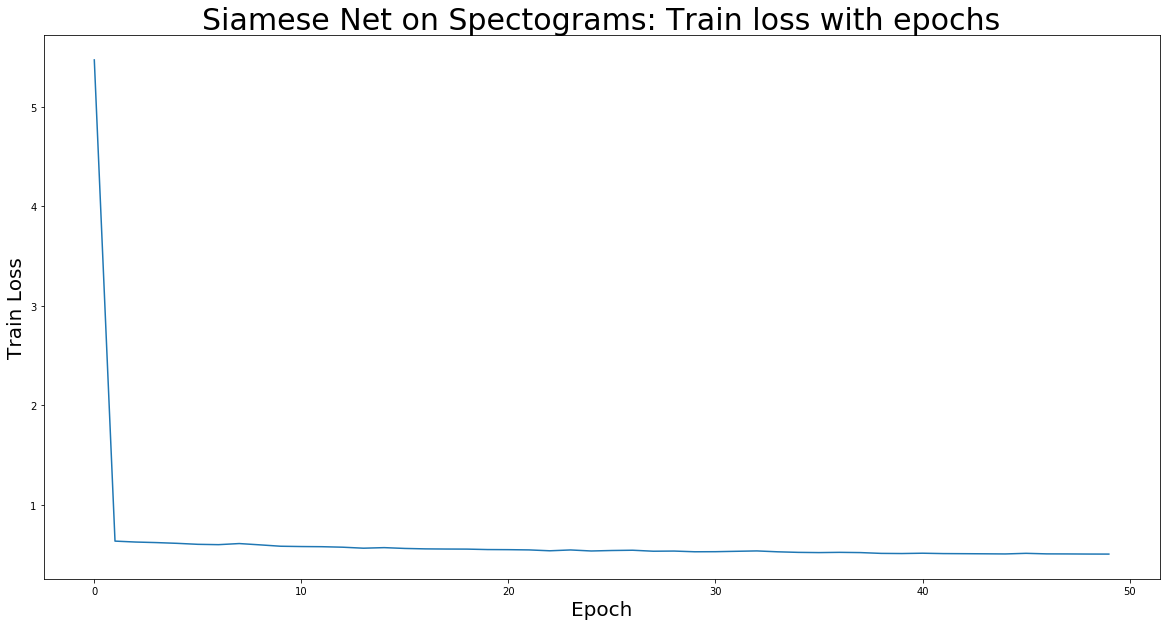

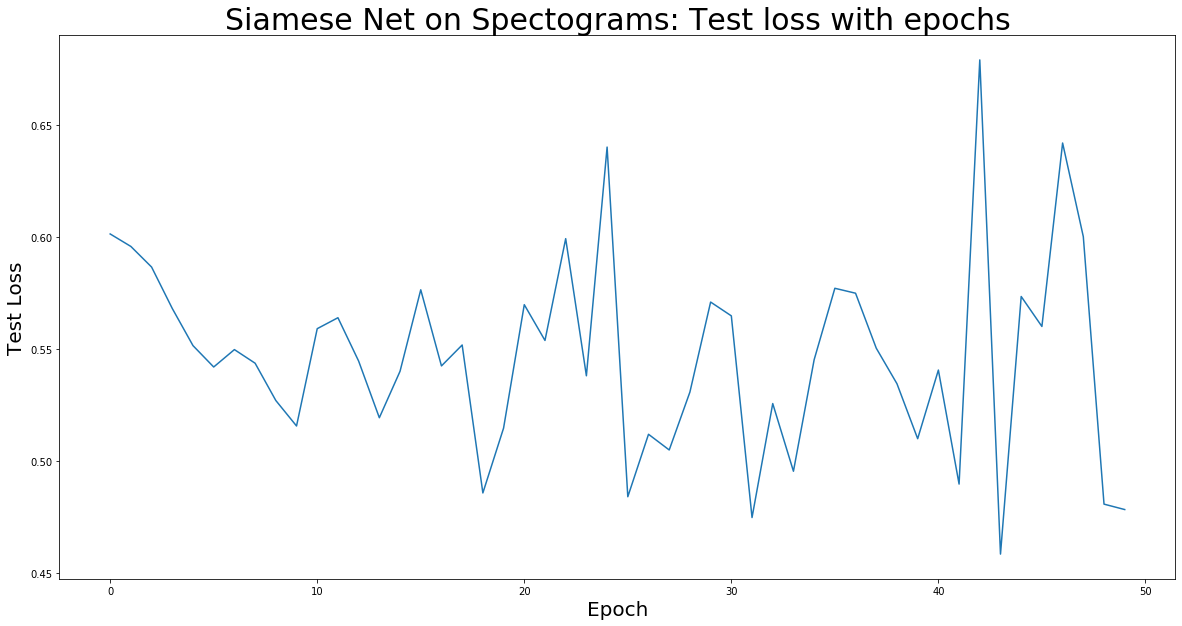

In [39]:
train_losses_ep, train_losses_val = zip(*train_losses)
my_plot(train_losses_ep, train_losses_val, 'Siamese Net on Spectograms: Train loss with epochs', 'Epoch', 'Train Loss')
test_losses_ep, test_losses_val = zip(*test_losses)
my_plot(test_losses_ep, test_losses_val, 'Siamese Net on Spectograms: Test loss with epochs', 'Epoch', 'Test Loss')

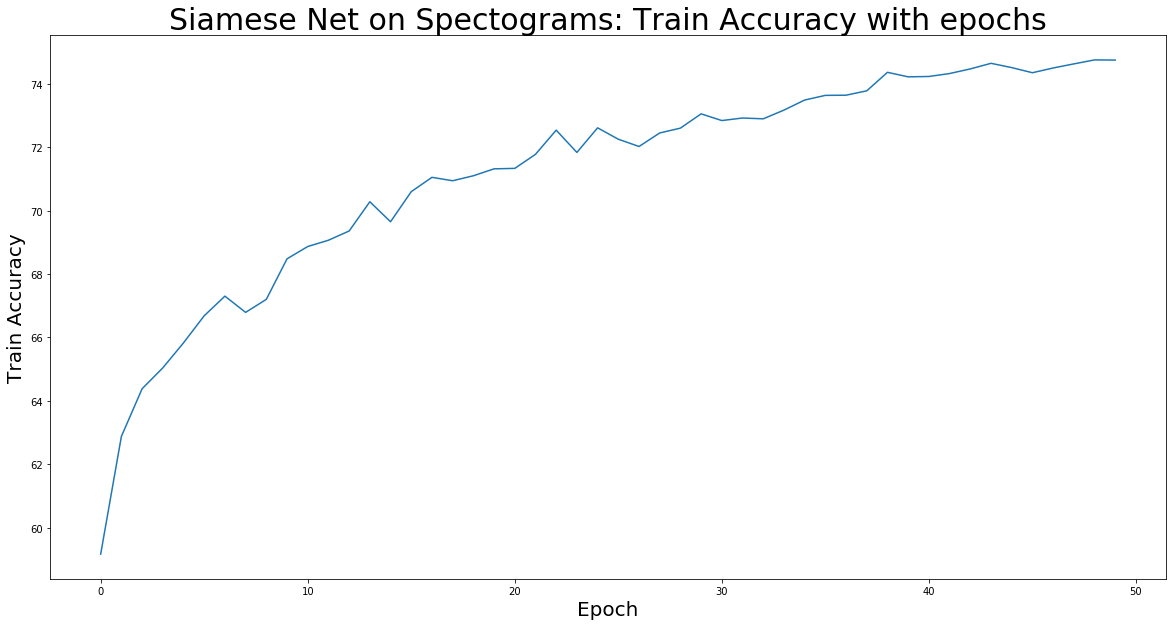

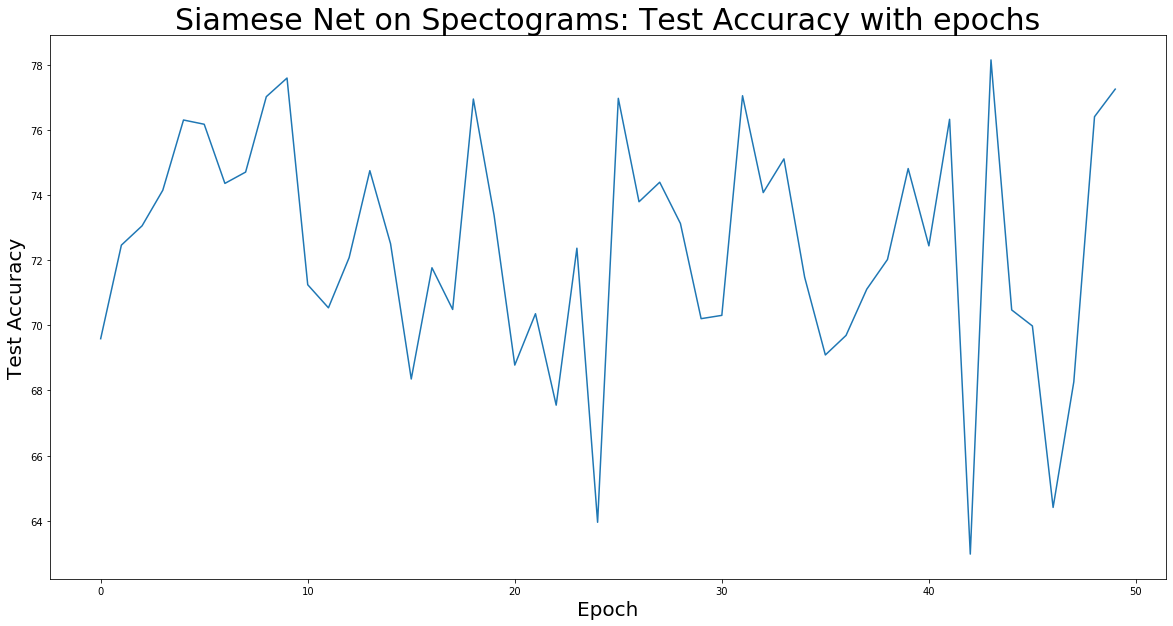

In [40]:
train_accuracies_ep, train_accuracies_val = zip(*train_accuracies)
my_plot(train_accuracies_ep, train_accuracies_val, 'Siamese Net on Spectograms: Train Accuracy with epochs', 'Epoch', 'Train Accuracy')
test_accuracies_ep, test_accuracies_val = zip(*test_accuracies)
my_plot(test_accuracies_ep, test_accuracies_val, 'Siamese Net on Spectograms: Test Accuracy with epochs', 'Epoch', 'Test Accuracy')

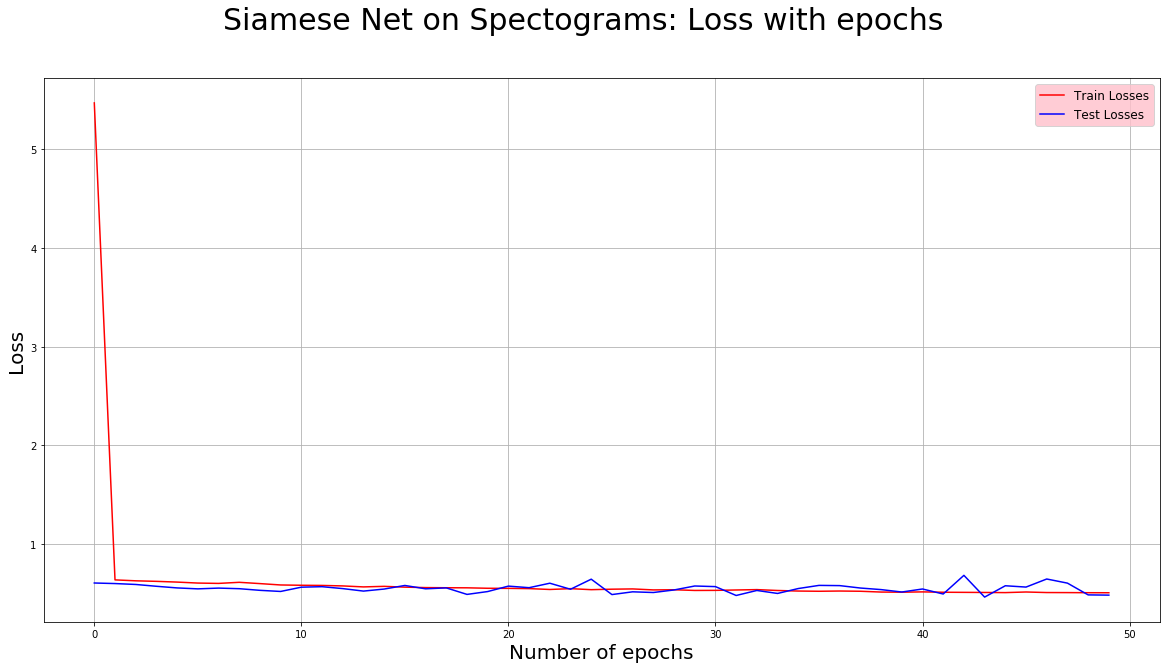

In [41]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(20,10))

ax.plot(train_losses_ep, train_losses_val, 'r', label='Train Losses')
ax.plot(test_losses_ep, test_losses_val, 'b', label='Test Losses')

legend = ax.legend(loc='best', fontsize='large')

legend.get_frame().set_facecolor('pink')

plt.suptitle('Siamese Net on Spectograms: Loss with epochs', fontsize=30)
plt.xlabel('Number of epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.grid(True)
plt.show()

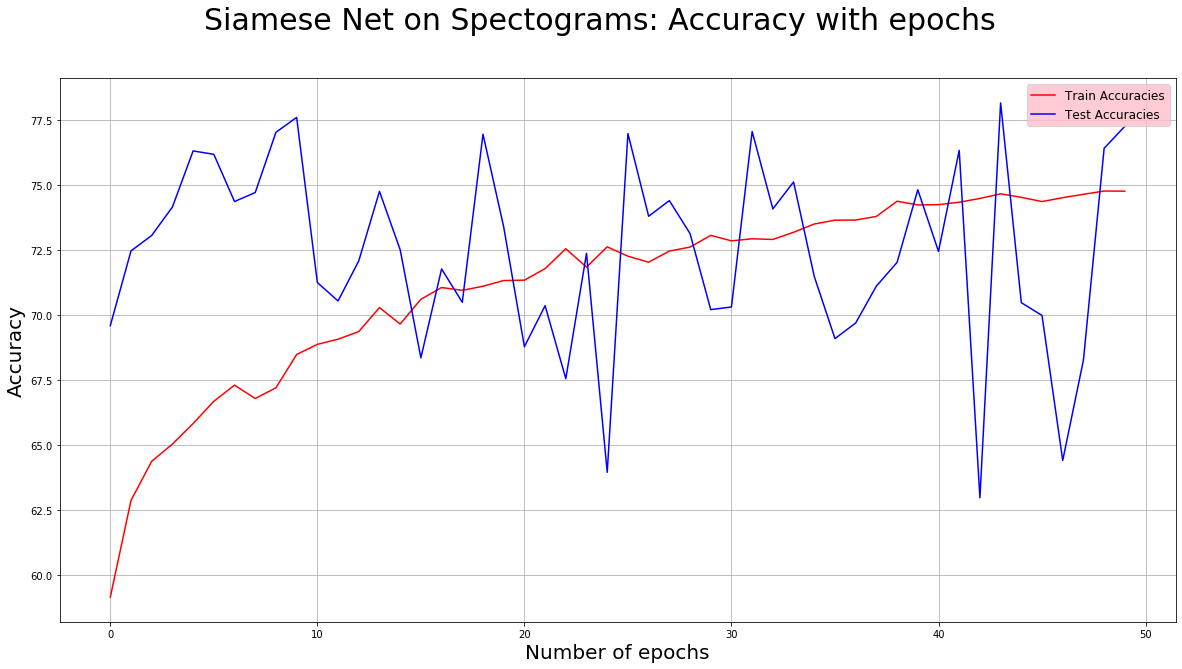

In [42]:
fig, ax = plt.subplots(figsize=(20,10))

ax.plot(train_accuracies_ep, train_accuracies_val, 'r', label='Train Accuracies')
ax.plot(test_accuracies_ep, test_accuracies_val, 'b', label='Test Accuracies')

legend = ax.legend(loc='best', fontsize='large')

legend.get_frame().set_facecolor('pink')

plt.suptitle('Siamese Net on Spectograms: Accuracy with epochs', fontsize=30)
plt.xlabel('Number of epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.grid(True)
plt.show()

## As opposed to the above plots, the ones below are for the case WITHOUT any dropout

In [45]:
!pwd

/gdrive/Shared drives/Deep Learning Project


In [0]:
train_losses_noDropout = np.load('train_losses.npy')
test_losses_noDropout = np.load('test_losses.npy')
train_accuracies_noDropout = np.load('train_accuracies.npy')
test_accuracies_noDropout = np.load('test_accuracies.npy')

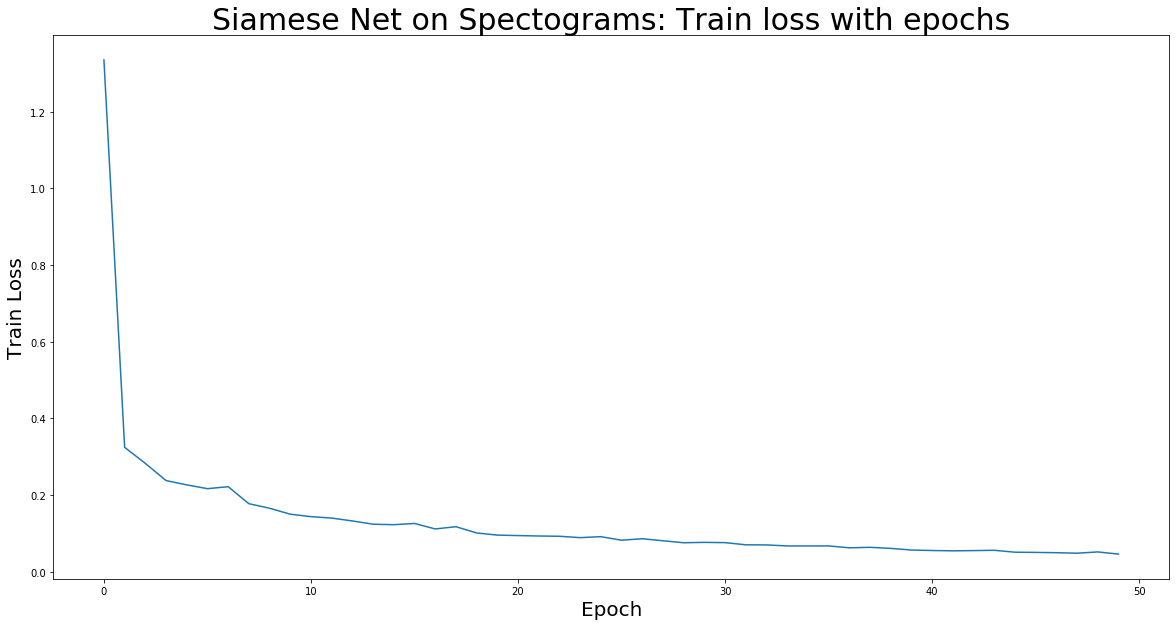

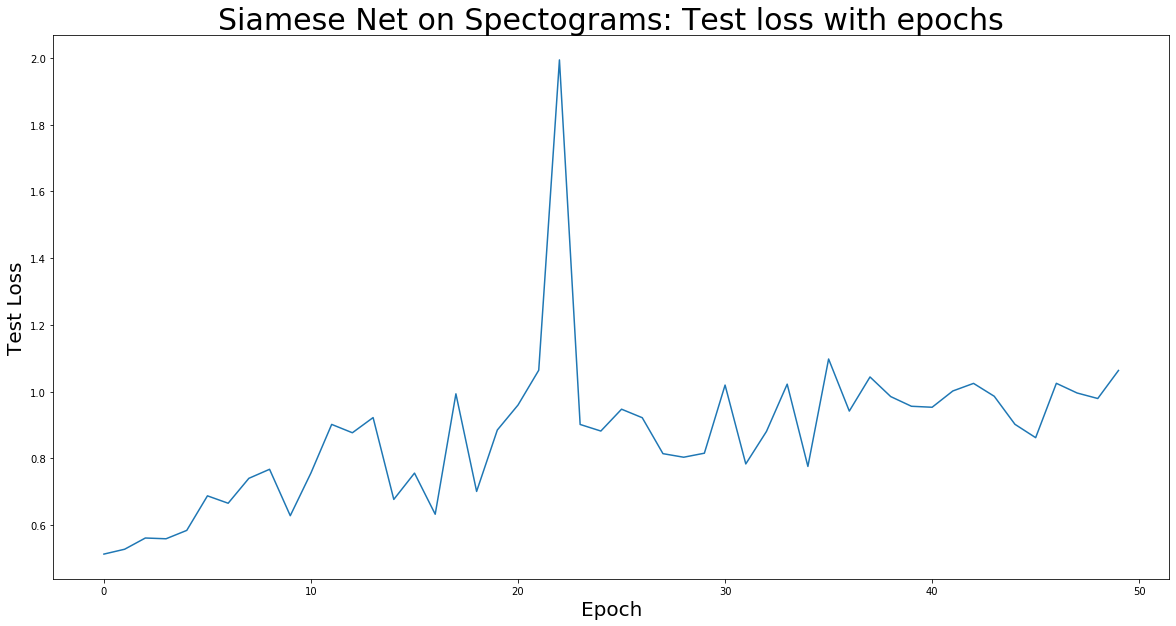

In [49]:
train_losses_ep, train_losses_val = zip(*train_losses_noDropout)
my_plot(train_losses_ep, train_losses_val, 'Siamese Net on Spectograms: Train loss with epochs', 'Epoch', 'Train Loss')
test_losses_ep, test_losses_val = zip(*test_losses_noDropout)
my_plot(test_losses_ep, test_losses_val, 'Siamese Net on Spectograms: Test loss with epochs', 'Epoch', 'Test Loss')

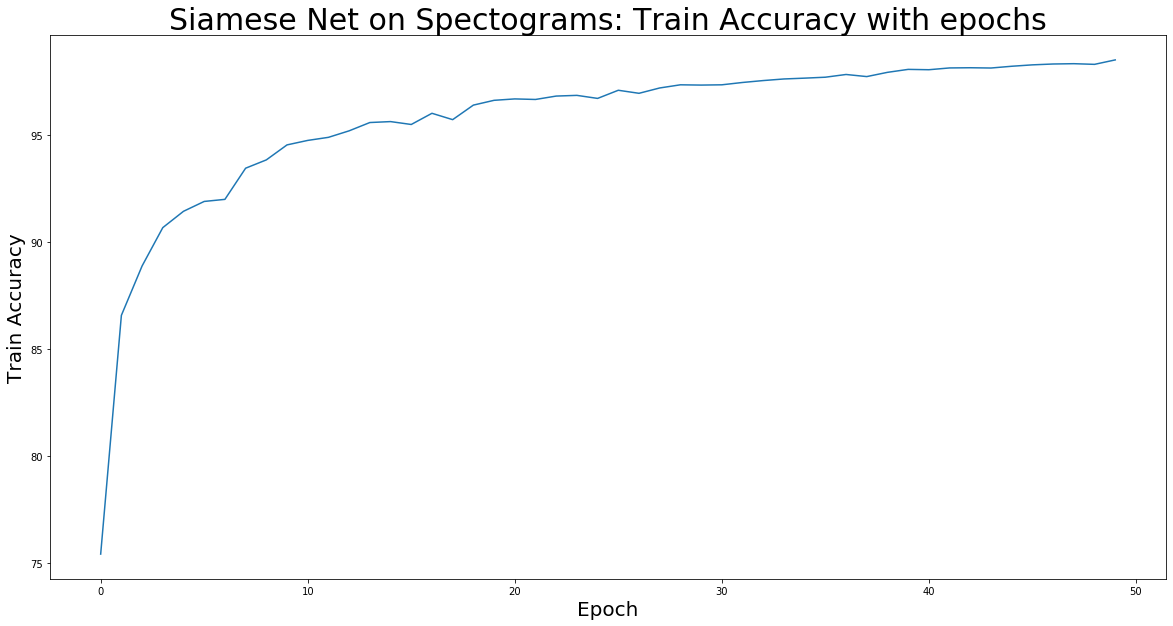

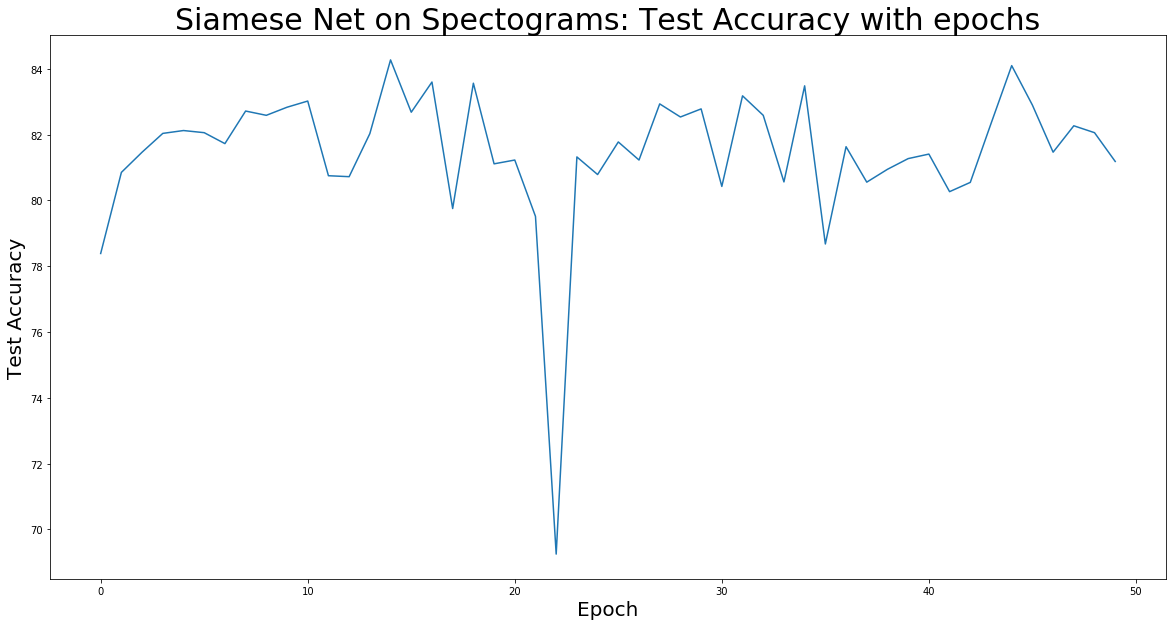

In [50]:
train_accuracies_ep, train_accuracies_val = zip(*train_accuracies_noDropout)
my_plot(train_accuracies_ep, train_accuracies_val, 'Siamese Net on Spectograms: Train Accuracy with epochs', 'Epoch', 'Train Accuracy')
test_accuracies_ep, test_accuracies_val = zip(*test_accuracies_noDropout)
my_plot(test_accuracies_ep, test_accuracies_val, 'Siamese Net on Spectograms: Test Accuracy with epochs', 'Epoch', 'Test Accuracy')

In [0]:
## These are the ones with Dropout
train_accuracies_ep_D, train_accuracies_val_D = zip(*train_accuracies)
test_accuracies_ep_D, test_accuracies_val_D = zip(*test_accuracies)

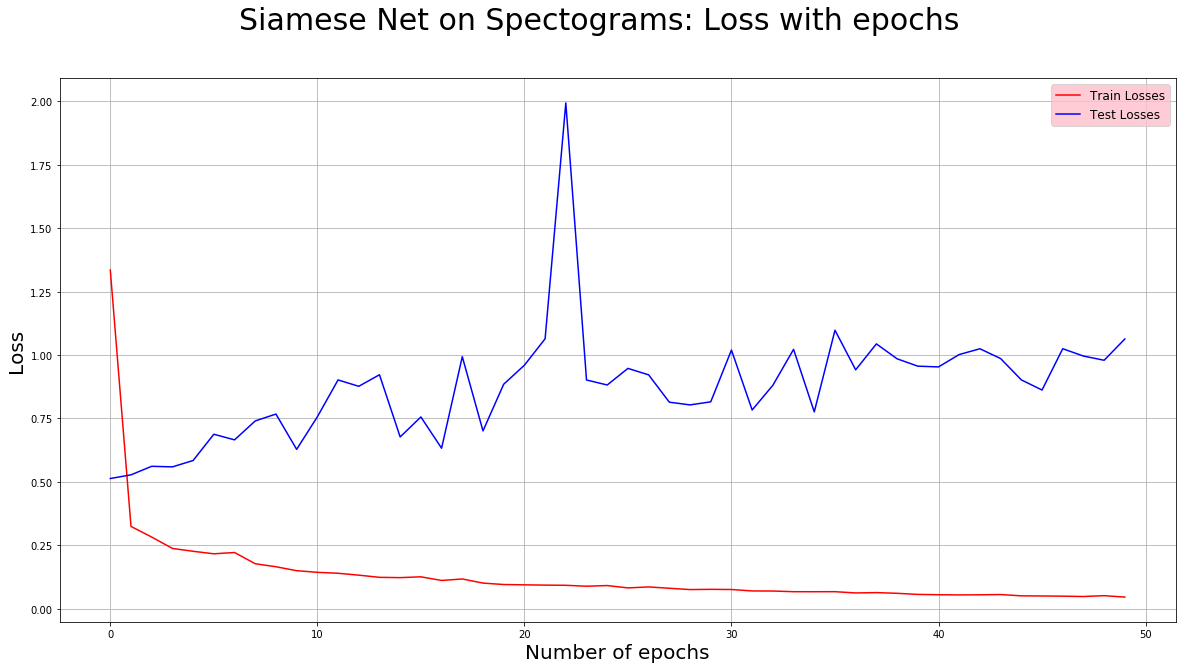

In [51]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(20,10))

ax.plot(train_losses_ep, train_losses_val, 'r', label='Train Losses')
ax.plot(test_losses_ep, test_losses_val, 'b', label='Test Losses')

legend = ax.legend(loc='best', fontsize='large')

legend.get_frame().set_facecolor('pink')

plt.suptitle('Siamese Net on Spectograms: Loss with epochs', fontsize=30)
plt.xlabel('Number of epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.grid(True)
plt.show()

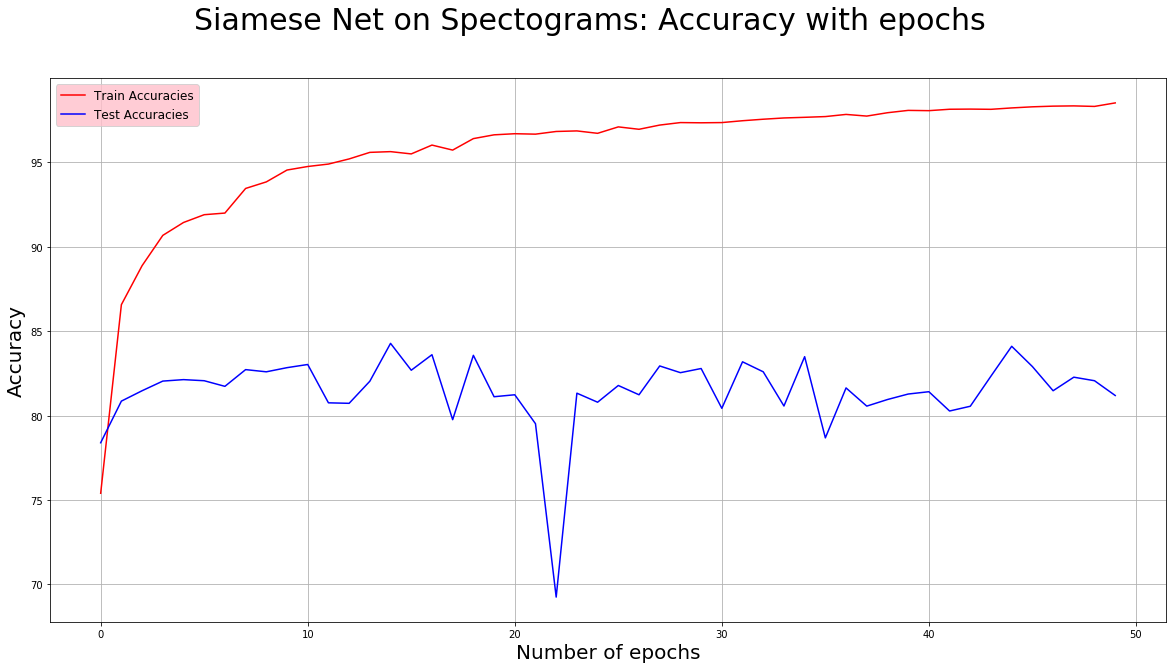

In [52]:
fig, ax = plt.subplots(figsize=(20,10))

ax.plot(train_accuracies_ep, train_accuracies_val, 'r', label='Train Accuracies')
ax.plot(test_accuracies_ep, test_accuracies_val, 'b', label='Test Accuracies')

legend = ax.legend(loc='best', fontsize='large')

legend.get_frame().set_facecolor('pink')

plt.suptitle('Siamese Net on Spectograms: Accuracy with epochs', fontsize=30)
plt.xlabel('Number of epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.grid(True)
plt.show()

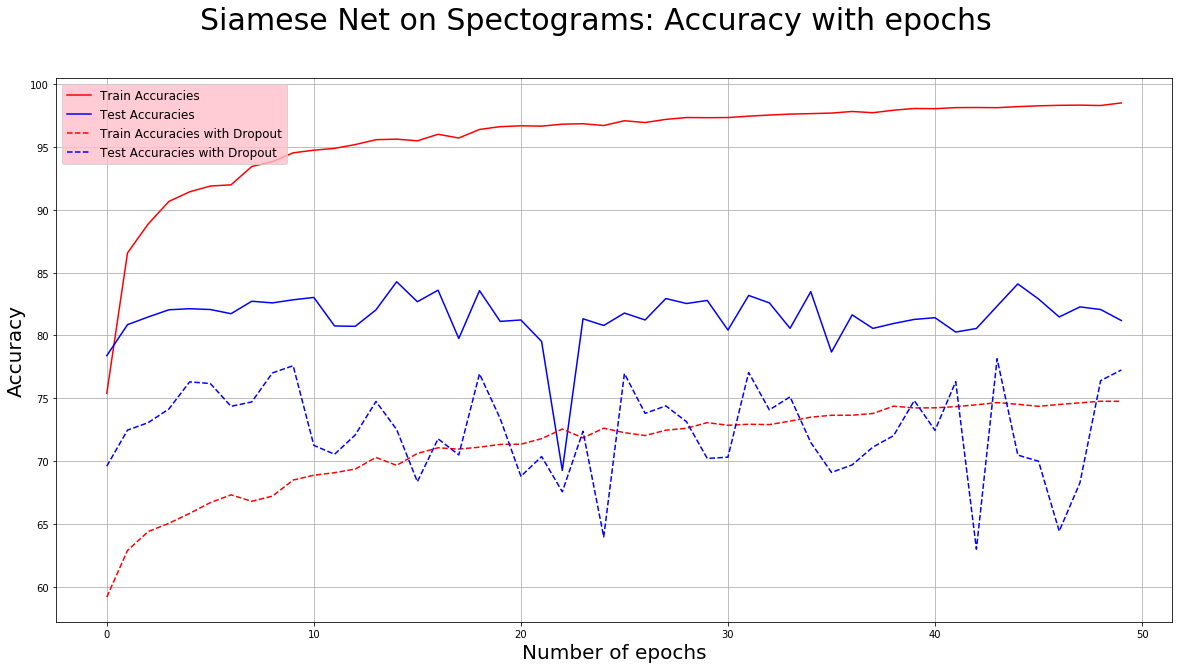

In [54]:
fig, ax = plt.subplots(figsize=(20,10))

ax.plot(train_accuracies_ep, train_accuracies_val, 'r', label='Train Accuracies')
ax.plot(test_accuracies_ep, test_accuracies_val, 'b', label='Test Accuracies')
ax.plot(train_accuracies_ep_D, train_accuracies_val_D, 'r--', label='Train Accuracies with Dropout')
ax.plot(test_accuracies_ep_D, test_accuracies_val_D, 'b--', label='Test Accuracies with Dropout')

legend = ax.legend(loc='best', fontsize='large')

legend.get_frame().set_facecolor('pink')

plt.suptitle('Siamese Net on Spectograms: Accuracy with epochs', fontsize=30)
plt.xlabel('Number of epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.grid(True)
plt.show()

In [0]:
train_losses_ep_D, train_losses_val_D = zip(*train_losses)
test_losses_ep_D, test_losses_val_D = zip(*test_losses)

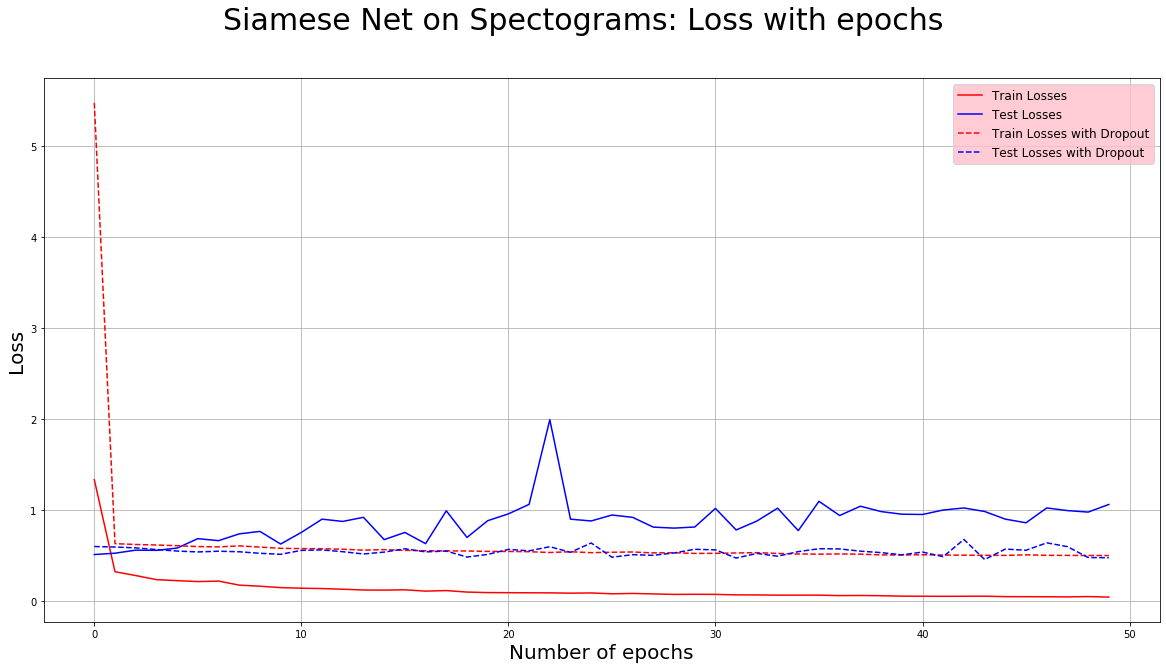

In [56]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(20,10))

ax.plot(train_losses_ep, train_losses_val, 'r', label='Train Losses')
ax.plot(test_losses_ep, test_losses_val, 'b', label='Test Losses')
ax.plot(train_losses_ep_D, train_losses_val_D, 'r--', label='Train Losses with Dropout')
ax.plot(test_losses_ep_D, test_losses_val_D, 'b--', label='Test Losses with Dropout')
legend = ax.legend(loc='best', fontsize='large')

legend.get_frame().set_facecolor('pink')

plt.suptitle('Siamese Net on Spectograms: Loss with epochs', fontsize=30)
plt.xlabel('Number of epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.grid(True)
plt.show()